<a href="https://colab.research.google.com/github/galdir/PGA_regression_with_PSA_clusters/blob/main/Peak_ground_acceleration_regression_with_psa_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accurate estimation of Peak Ground Acceleration (PGA) is crucial for assessing the potential destructiveness of seismic events and guiding infrastructure inspection and resource allocation. While many PGA forecasting methods rely on local soil data, such information is often unavailable due to high acquisition costs.

Our study aims to show that an artificial intelligence ensemble approach can improve PGA prediction by using machine learning clustering techniques applied to Pseudo-Spectral Accelerations (PSA) data as an alternative to missing soil information.

This Notebook processes data from the National Autonomous University of Mexico (UNAM). To access this data, a request must be made directly to UNAM.

The Notebook requires four files:
* earthquakes_pga.csv
  * Columns: ['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth']
* earthquakes_psa.csv
  * This file has PSAs from seismic stations, with 1000 samples each, arranged in columns. The first column has the index of each sample and each subsequent column represents the PSA of an axis of a seismic station, with NS to indicate the North-South axis, EW to indicate the East-West axis and V to indicate the vertical axis. The first columns are: ['period', 'ACAP8509191-EW', 'ACAP8509191-NS', 'ACAP8509191-V', 'ACAS8509191-EW', 'ACAS8509191-NS', 'ACAS8509191-V', 'APAT8509191-EW', 'APAT8509191-NS', 'APAT8509191-V', ...]
* mex_admbndl_admALL_govmex_itos_20210618.shp
  * Its a shape file used to plot maps. Found here https://data.humdata.org/dataset/cod-ab-mex?
* mex_admbndl_admALL_govmex_itos_20210618.shx
  * Its a shape file used to plot maps. Found here https://data.humdata.org/dataset/cod-ab-mex?

#Setup

In [213]:
!pip install -q -U keras-tuner

In [214]:
pip install cartopy


In [215]:
pip install optuna

In [216]:
!pip install gdown

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

import geopandas as gpd

from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import randint, uniform

from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

import keras_tuner as kt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import mean_squared_error, root_mean_squared_error

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score

from scipy import stats


import pickle
import joblib
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import xgboost as xgb

import sklearn

import optuna
from sklearn.model_selection import cross_val_score

import copy



In [218]:
load_trained_models = True
hiperparameters_tuning = False

In [219]:
tf.random.set_seed(42)


In [220]:
raw_earthquakes_pga_url = 'https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/main/earthquakes_pga.csv'

In [221]:
df_raw = pd.read_csv(raw_earthquakes_pga_url)
print(df_raw.shape)

(1663, 28)


In [222]:
raw_earthquakes_psa_url = 'https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/main/earthquakes_psa.csv'

df_psa_merged=pd.read_csv(raw_earthquakes_psa_url)
print(df_psa_merged.shape)

(1000, 1653)


In [223]:
df_raw.describe()

,magnitude,peak_ground_acceleration,epicentral_distance,depth,earthquake_latitude,earthquake_longitude,station_latitude,station_longitude,duration,incidence_angle,hypocentral_distance,azimuth,angle_to_the_nearest_horizontal_sensor,calculated_epicentral_distance,calculated_hypocentral_distance,calculated_incidence_angle,calculated_azimuth
count,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000,1663.000000
mean,6.709140,30.547727,294.182802,25.808479,16.880823,-99.034177,18.015303,-98.852161,144.961286,7.788257,296.628419,170.090991,22.573233,292.986578,295.434724,7.747713,13.597078
std,0.659021,67.799642,177.833432,17.591827,1.159963,2.809492,1.200115,2.055719,90.002289,9.002623,176.507544,58.848907,12.758065,177.076743,175.757548,8.894259,73.489644
min,5.900000,0.210000,5.000000,4.000000,14.027200,-107.330000,14.922677,-105.240699,6.800000,0.627530,8.944272,90.000002,0.037634,5.994139,9.235785,0.608239,-179.919132
25%,6.000000,3.710000,163.000000,12.000000,16.240000,-101.120000,16.997788,-99.851570,78.337500,2.422923,165.491584,116.638690,10.584277,163.810263,165.640802,2.466413,-49.621313
50%,6.500000,8.880000,283.000000,19.000000,16.795000,-98.720000,17.988778,-99.156000,134.410000,4.202158,285.506567,158.921763,22.303576,282.929480,284.877777,4.283325,6.894682
75%,7.200000,24.630000,377.000000,38.500000,17.980000,-97.877300,19.325266,-97.865638,191.000000,10.151467,377.641364,231.966689,33.491877,375.167353,376.737621,9.891179,74.808352
max,8.200000,1073.510000,1346.000000,69.700000,19.040000,-91.930000,20.682656,-92.270957,991.000000,82.874984,1346.782391,269.966961,44.982814,1345.394793,1346.177536,80.412637,177.376211


In [224]:
!wget 'https://github.com/galdir/PGA_regression_with_PSA_clusters/raw/refs/heads/main/ne_110m_admin_0_countries.shp'

--2025-08-24 16:20:54--  https://github.com/galdir/PGA_regression_with_PSA_clusters/raw/refs/heads/main/ne_110m_admin_0_countries.shp
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/refs/heads/main/ne_110m_admin_0_countries.shp [following]
--2025-08-24 16:20:54--  https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/refs/heads/main/ne_110m_admin_0_countries.shp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180924 (177K) [application/octet-stream]
Saving to: ‘ne_110m_admin_0_countries.shp.1’

ne_110m_admin_0_cou 100%[=================

In [225]:
!wget 'https://github.com/galdir/PGA_regression_with_PSA_clusters/raw/refs/heads/main/ne_110m_admin_0_countries.shx'

--2025-08-24 16:20:55--  https://github.com/galdir/PGA_regression_with_PSA_clusters/raw/refs/heads/main/ne_110m_admin_0_countries.shx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/refs/heads/main/ne_110m_admin_0_countries.shx [following]
--2025-08-24 16:20:55--  https://raw.githubusercontent.com/galdir/PGA_regression_with_PSA_clusters/refs/heads/main/ne_110m_admin_0_countries.shx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1516 (1.5K) [application/octet-stream]
Saving to: ‘ne_110m_admin_0_countries.shx.1’

ne_110m_admin_0_cou 100%[===================

In [226]:
!gdown --id 1hwy0mZlP8128W_vghZYFlXkzdNTo5Fmh

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1hwy0mZlP8128W_vghZYFlXkzdNTo5Fmh
From (redirected): https://drive.google.com/uc?id=1hwy0mZlP8128W_vghZYFlXkzdNTo5Fmh&confirm=t&uuid=ce6401e2-7a27-471a-b186-8a539d0e8ef9
To: /content/paper_1_results.zip
100% 439M/439M [00:10<00:00, 40.3MB/s]


In [227]:
!unzip paper_1_results.zip

Archive:  paper_1_results.zip
replace experiments_results.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Remove registers from stations without psa data

In the PGA dataset, there are seismic stations for which we did not have access to any PSA data, so we will not use their data.

In [228]:
columns = df_psa_merged.columns
station_keys = []

for i in range(0, len(columns)):
  col_split=columns[i].split("-")
  if(columns[i] == 'period'):
    continue
  station_keys.append(columns[i][:4])

station_keys_set = set(station_keys)

print(station_keys_set)

{'FEPP', 'SLUI', 'PRJS', 'TX5A', 'ACAN', 'CANA', 'TXS4', 'CUMV', 'TXCR', 'NITA', 'ACP2', 'PARS', 'OMTP', 'TXS1', 'VNTA', 'RIOG', 'VILE', 'HMTT', 'ZACA', 'CSER', 'THEZ', 'APAT', 'CDAO', 'CAOE', 'PMOP', 'RFPP', 'NUX2', 'CPDR', 'MSAS', 'OXJM', 'PANG', 'NILT', 'XALA', 'TEJU', 'ACAR', 'JPSK', 'PAPN', 'UNIO', 'JAMI', 'SCCB', 'PRJP', 'TACY', 'COPL', 'CTCL', 'DFVG', 'AZIH', 'OXCU', 'SCRU', 'COLL', 'OXAE', 'SLPA', 'ACAM', 'OXBJ', 'PMOS', 'CHI1', 'ACPD', 'SAPP', 'TNLP', 'OXXO', 'SCT2', 'TXCL', 'ACAP', 'CLON', 'TAMA', 'CUP4', 'CCCL', 'CDGU', 'TOTO', 'SMR2', 'MADI', 'SCT1', 'POZU', 'COYC', 'PET2', 'TLHD', 'PBP2', 'SMLC', 'CAOO', 'CAYR', 'SJLL', 'SXVI', 'CUP1', 'TGBT', 'CUIP', 'PNTP', 'COYQ', 'SODO', 'DFRO', 'CHFL', 'CAOT', 'ATYC', 'GDLP', 'PROM', 'SXPU', 'LMPP', 'FICA', 'MIHL', 'OXTO', 'CHPA', 'CUP2', 'LANE', 'CAYA', 'MARU', 'VHSA', 'CDAF', 'SUCH', 'HUAM', 'CU01', 'SRPU', 'OAXM', 'TX5B', 'TEAC', 'RABO', 'TXSO', 'ACAS', 'OXAL', 'COMD', 'CUP3', 'XALT', 'URUA', 'OCTT', 'SNJE', 'COMA', 'GALE', 'SLU2',

In [229]:
psa_station_keys_set = station_keys_set

In [230]:
len(psa_station_keys_set)

148

In [231]:
pga_station_keys_set = df_raw.station_key.unique()

In [232]:
len(pga_station_keys_set)

172

In [233]:
pga_stations_without_psa = set(pga_station_keys_set) - set(psa_station_keys_set)

In [234]:
len(pga_stations_without_psa)

24

In [235]:
pga_stations_with_psa = set(pga_station_keys_set) - pga_stations_without_psa

In [236]:
len(pga_stations_with_psa)

148

In [237]:
df_raw.shape

(1663, 28)

In [238]:
df_raw.query('station_key in @pga_stations_with_psa').shape

(1614, 28)

In [239]:
df_stations_with_PSA = df_raw.query('station_key in @pga_stations_with_psa')

In [240]:
df_stations_with_PSA.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [241]:
df_stations_with_PSA.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662],
      dtype='int64', length=1614)

In [242]:
df_stations_with_PSA.reset_index(inplace=True, drop=True)

In [243]:
df_stations_with_PSA.head()

,date,time,magnitude,institution,entity,station_key,station_name,peak_ground_acceleration,quality,file,...,duration,incidence_angle,hypocentral_distance,azimuth,angle_to_the_nearest_horizontal_sensor,calculated_epicentral_distance,calculated_hypocentral_distance,calculated_incidence_angle,source_off_shore,calculated_azimuth
0,2018-02-16,23:39:39,7.2,I de I-UNAM,GRO,SLU2,SAN LUIS DE LA LOMA 2,2.94,A,SLU21802.161,...,133.0,2.750835,333.384163,109.987575,21.215506,333.015189,333.399334,2.750710,False,-68.901392
1,2018-02-16,23:39:39,7.2,I de I-UNAM,OAX,SMLC,SAN MARTIN LOS CANSECO,23.38,A,SMLC1802.161,...,210.0,6.296819,145.880088,251.209162,19.712860,145.432447,146.309933,6.278245,False,70.398457
2,2018-02-16,23:39:39,7.2,I de I-UNAM,MIC,SNJE,SAN JERONIMO,3.51,A,SNJE1802.161,...,157.0,2.106481,435.294153,124.990997,36.743086,435.294924,435.588879,2.105055,False,-53.423946
3,2018-02-16,23:39:39,7.2,I de I-UNAM,VER,SODO,SOLEDAD DE DOBLADO,8.76,A,SODO1802.161,...,270.0,2.580599,355.360380,209.494929,28.090209,355.845160,356.204686,2.574478,False,28.236455
4,2018-02-16,23:39:39,7.2,I de I-UNAM,GRO,SUCH,EL SUCHIL,4.41,A,SUCH1802.161,...,138.0,3.042759,301.424949,111.011136,22.227069,301.327132,301.751621,3.039462,False,-67.894639


In [244]:
df = df_stations_with_PSA

In [245]:
df.shape

(1614, 28)

# Data Description and Analysis

In [246]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   date                                    1614 non-null   object 
 1   time                                    1614 non-null   object 
 2   magnitude                               1614 non-null   float64
 3   institution                             1614 non-null   object 
 4   entity                                  1614 non-null   object 
 5   station_key                             1614 non-null   object 
 6   station_name                            1614 non-null   object 
 7   peak_ground_acceleration                1614 non-null   float64
 8   quality                                 1614 non-null   object 
 9   file                                    1614 non-null   object 
 10  epicentral_distance                     1614 non-null   int6

In [248]:
df.station_key.unique().shape

(148,)

In [249]:
df.date.max()

'2018-02-19'

In [250]:
df.date =  pd.to_datetime(df.copy().date)

/tmp/ipython-input-266619656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.date =  pd.to_datetime(df.copy().date)


[Text(0.5, 0, 'Hypocentral Distance (km)')]

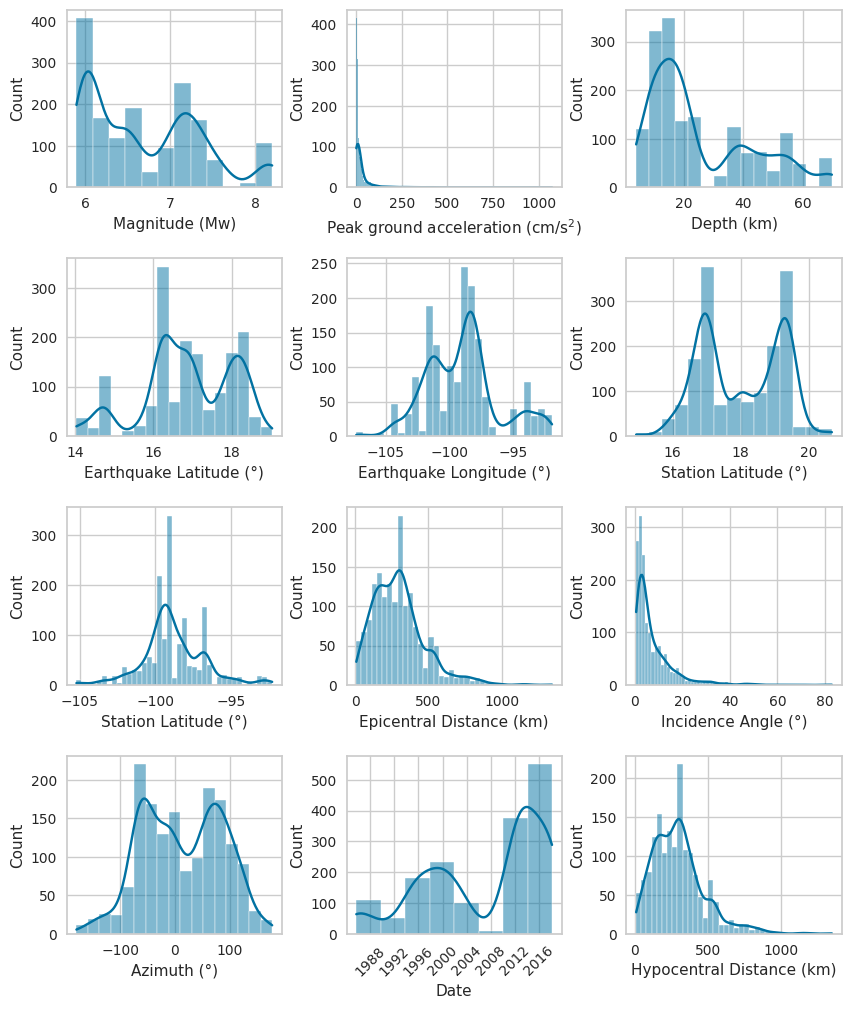

In [251]:
fig, axs = plt.subplots(4, 3, figsize=(10, 12))

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Aumentei o espaçamento entre os subplots

sns.histplot(data=df, x="magnitude", kde=True, ax=axs[0, 0])
axs[0,0].set(xlabel="Magnitude (Mw)")

sns.histplot(data=df, x="peak_ground_acceleration", kde=True, ax=axs[0, 1])
axs[0,1].set(xlabel="Peak ground acceleration (cm/s$^2$)")

sns.histplot(data=df, x="depth", kde=True, ax=axs[0, 2])
axs[0,2].set(xlabel="Depth (km)")

sns.histplot(data=df, x="earthquake_latitude", kde=True, ax=axs[1, 0])
axs[1,0].set(xlabel="Earthquake Latitude (°)")

sns.histplot(data=df, x="earthquake_longitude", kde=True, ax=axs[1, 1])
axs[1,1].set(xlabel="Earthquake Longitude (°)")

sns.histplot(data=df, x="station_latitude", kde=True, ax=axs[1, 2])
axs[1,2].set(xlabel="Station Latitude (°)")

sns.histplot(data=df, x="station_longitude", kde=True, ax=axs[2, 0])
axs[2, 0].set(xlabel="Station Latitude (°)")

sns.histplot(data=df, x="calculated_epicentral_distance", kde=True, ax=axs[2, 1])
axs[2, 1].set(xlabel="Epicentral Distance (km)")

sns.histplot(data=df, x="incidence_angle", kde=True, ax=axs[2, 2])
axs[2, 2].set(xlabel="Incidence Angle (°)")

sns.histplot(data=df, x="calculated_azimuth", kde=True, ax=axs[3, 0])
axs[3, 0].set(xlabel="Azimuth (°)")

sns.histplot(data=df, x="date", kde=True, bins=8, ax=axs[3, 1])
axs[3, 1].set(xlabel="Date")
# Rotacionar os rótulos do eixo x em 45 graus
axs[3, 1].tick_params(axis='x', rotation=45)

sns.histplot(data=df, x="calculated_hypocentral_distance", kde=True, ax=axs[3, 2])
axs[3, 2].set(xlabel="Hypocentral Distance (km)")



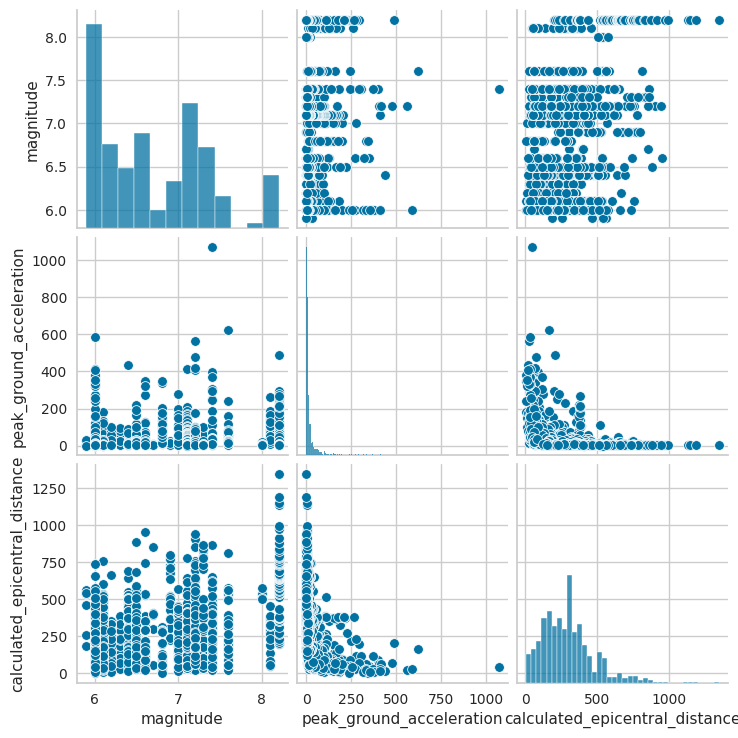

In [252]:
sns.pairplot(df[['magnitude','peak_ground_acceleration', 'calculated_epicentral_distance']])

## mapS

In [253]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth'],
      dtype='object')

In [254]:
locations = [
    [-99.1332, 19.4326, "Mexico City"],
]

map_file = 'ne_110m_admin_0_countries.shp'


world = gpd.read_file(map_file)



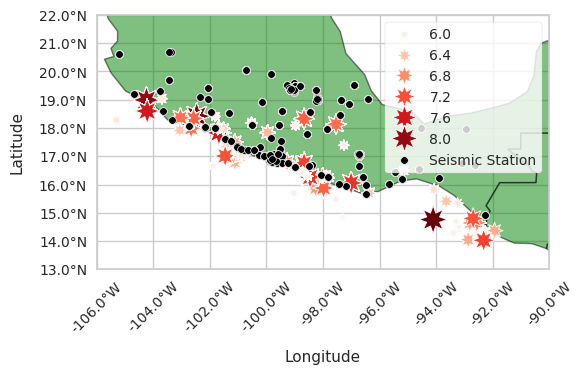

In [255]:
fig, ax1 = plt.subplots(figsize=(6, 4))

world.plot(ax=ax1, edgecolor='black', facecolor='green', linewidth=1, zorder=1, alpha=0.5)

sns.scatterplot(ax=ax1,
                    data=df,
                    x='earthquake_longitude',
                    y='earthquake_latitude',
                    size='magnitude',
                    hue='magnitude',
                    sizes=(40, 400),
                    zorder=2,
                    palette=sns.color_palette("Reds", as_cmap=True),
                    marker=(8,1,0))

sns.scatterplot(ax=ax1,
                data=df,
                x='station_longitude',
                y='station_latitude',
                zorder=3,
                color='black',
                s=30,
                label='Seismic Station')


ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Intervalo de 2 graus
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Intervalo de 1 grau

def longitude_formatter(x, p):
    return f'{x}°W'

def latitude_formatter(x, p):
    return f'{x}°N'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(longitude_formatter))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(latitude_formatter))

plt.xticks(rotation=45)

ax1.set_xlabel('Longitude', labelpad=10)
ax1.set_ylabel('Latitude', labelpad=10)
plt.xlim([-106, -90])
plt.ylim([13, 22])

plt.legend(frameon=True)

plt.tight_layout()

plt.show()

## One event

In [256]:
one_event = df[df['date']=='2017-09-19 00:00:00']

In [257]:
one_event.shape

(73, 28)

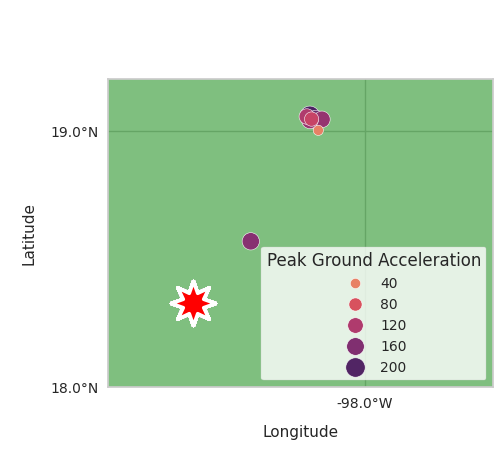

In [258]:
# Faça o plot
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plote o contorno do México
world.plot(ax=ax1, edgecolor='black', facecolor='green', linewidth=1, zorder=1, alpha=0.5)

# Adicionar marcadores para cada localização
for lon, lat, name in locations:
    ax1.plot(lon, lat, 'ko', markersize=3)
    ax1.text(lon, lat, name, color='w', fontsize=8, ha='right', va='bottom')


#ax1 = map.plot(figsize=(8, 6), alpha=0.5)
#ax1.set(xlabel='Longitude', ylabel='Latitude')

sns.scatterplot(ax=ax1,
                data=one_event,
                x='earthquake_longitude',
                y='earthquake_latitude',
                color='red',
                s=1000,
                zorder=2,
                #palette=pal,
                marker=(8,1,0))

sns.scatterplot(ax=ax1,
                data=one_event,
                x='station_longitude',
                y='station_latitude',
                zorder=2,
                hue='peak_ground_acceleration',
                size='peak_ground_acceleration',
                palette=sns.color_palette("flare", as_cmap=True),
                sizes=(20, 200))
plt.xlim([-99, -97.5])
plt.ylim([18, 19.2])

# Definir intervalos para os ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Intervalo de 2 graus
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Intervalo de 1 grau

# Formatar os labels com o símbolo de grau
def longitude_formatter(x, p):
    return f'{x}°W'

def latitude_formatter(x, p):
    return f'{x}°N'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(longitude_formatter))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(latitude_formatter))

# Rotacionar os labels do eixo x para melhor legibilidade
#plt.xticks(rotation=45)

# Ajustar os limites e labels
ax1.set_xlabel('Longitude', labelpad=10)
ax1.set_ylabel('Latitude', labelpad=10)

# Ajustar o layout para evitar cortes
#plt.tight_layout()


plt.legend(frameon=True, title='Peak Ground Acceleration', loc='lower right')

plt.show()




##PSA

In [259]:
df_psa_merged.shape

(1000, 1653)

In [260]:
df_psa_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1653 entries, period to XALA1802161-V
dtypes: float64(1653)
memory usage: 12.6 MB


In [261]:
print(list(df_psa_merged.columns))

['period', 'ACAP8509191-EW', 'ACAP8509191-NS', 'ACAP8509191-V', 'ACAS8509191-EW', 'ACAS8509191-NS', 'ACAS8509191-V', 'APAT8509191-EW', 'APAT8509191-NS', 'APAT8509191-V', 'ATYC8509191-EW', 'ATYC8509191-NS', 'ATYC8509191-V', 'AZIH8509191-EW', 'AZIH8509191-NS', 'AZIH8509191-V', 'CALE8509191-EW', 'CALE8509191-NS', 'CALE8509191-V', 'CALE8509192-EW', 'CALE8509192-NS', 'CALE8509192-V', 'CAYA8509191-EW', 'CAYA8509191-NS', 'CAYA8509191-V', 'CDAF8509191-EW', 'CDAF8509191-NS', 'CDAF8509191-V', 'CDAO8509191-EW', 'CDAO8509191-NS', 'CDAO8509191-V', 'CHI18509191-EW', 'CHI18509191-NS', 'CHI18509191-V', 'COYC8509191-EW', 'COYC8509191-NS', 'COYC8509191-V', 'CPDR8509191-EW', 'CPDR8509191-NS', 'CPDR8509191-V', 'CU018509191-EW', 'CU018509191-NS', 'CU018509191-V', 'CUIP8509191-EW', 'CUIP8509191-NS', 'CUIP8509191-V', 'CUMV8509191-EW', 'CUMV8509191-NS', 'CUMV8509191-V', 'FICA8509191-EW', 'FICA8509191-NS', 'FICA8509191-V', 'MADI8509191-EW', 'MADI8509191-NS', 'MADI8509191-V', 'MSAS8509191-EW', 'MSAS8509191-NS',

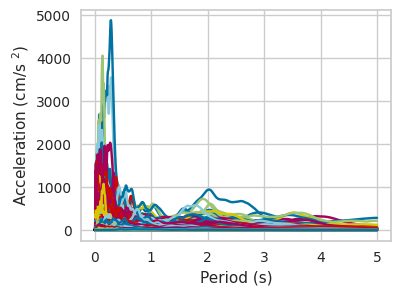

In [262]:
plt.figure(figsize=(4, 3))
plt.plot(df_psa_merged['period'], df_psa_merged.iloc[:, 1:-1])
plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s $^2$)')
plt.show()

unknown orientation


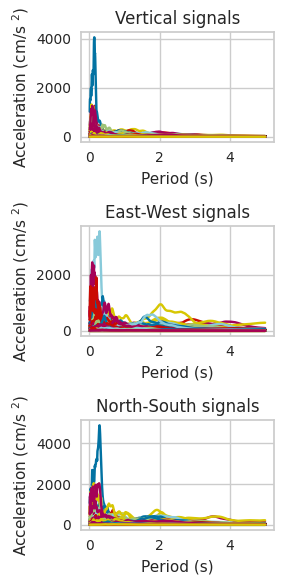

In [263]:
indexs_v = []
indexs_ew = []
indexs_ns = []

for column in df_psa_merged.columns:
  orientation = column.split("-")[-1]
  if orientation == 'V':
    indexs_v.append(column)
  elif orientation == 'EW':
    indexs_ew.append(column)
  elif orientation == 'NS':
    indexs_ns.append(column)
  else:
    print('unknown orientation')

fig, axs = plt.subplots(3, 1, figsize=(3,6))

axs[0].plot(df_psa_merged['period'].values, df_psa_merged[indexs_v].values)
axs[0].set_xlabel('Period (s)')
axs[0].set_ylabel('Acceleration (cm/s $^2$)')
axs[0].set_title('Vertical signals')

axs[1].plot(df_psa_merged['period'].values, df_psa_merged[indexs_ew].values)
axs[1].set_xlabel('Period (s)')
axs[1].set_ylabel('Acceleration (cm/s $^2$)')
axs[1].set_title('East-West signals')

axs[2].plot(df_psa_merged['period'].values, df_psa_merged[indexs_ns].values)
axs[2].set_xlabel('Period (s)')
axs[2].set_ylabel('Acceleration (cm/s $^2$)')
axs[2].set_title('North-South signals')

plt.tight_layout()

plt.show()


[16]


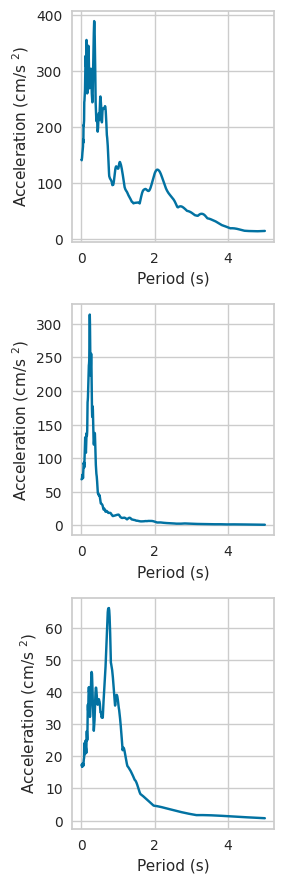

In [264]:
columns = df_psa_merged.columns


fig, axs = plt.subplots(3, 1, figsize=(3,9))

indexs_station = []

for i in range(len(columns)):
  actual_station_key = columns[i][:4]
  if actual_station_key == 'CALE':
    indexs_station.append(i)
    break

print(indexs_station)

axs[0].plot(df_psa_merged['period'].values, df_psa_merged.iloc[:, indexs_station].values)
axs[0].set_xlabel('Period (s)')
axs[0].set_ylabel('Acceleration (cm/s $^2$)')



indexs_station = []

for i in range(len(columns)):
  actual_station_key = columns[i][:4]
  if actual_station_key == 'ACAD':
    indexs_station.append(i)
    break

axs[1].plot(df_psa_merged['period'], df_psa_merged.iloc[:, indexs_station])
axs[1].set_xlabel('Period (s)')
axs[1].set_ylabel('Acceleration (cm/s $^2$)')



indexs_station = []


for i in range(len(columns)):
  actual_station_key = columns[i][:4]
  if actual_station_key == 'ACAS':
    indexs_station.append(i)
    break

axs[2].plot(df_psa_merged['period'], df_psa_merged.iloc[:, indexs_station])
axs[2].set_xlabel('Period (s)')
axs[2].set_ylabel('Acceleration (cm/s $^2$)')

plt.tight_layout()

plt.show()

[16, 17, 18, 19, 20, 21, 579, 580, 581, 708, 709, 710, 900, 901, 902]


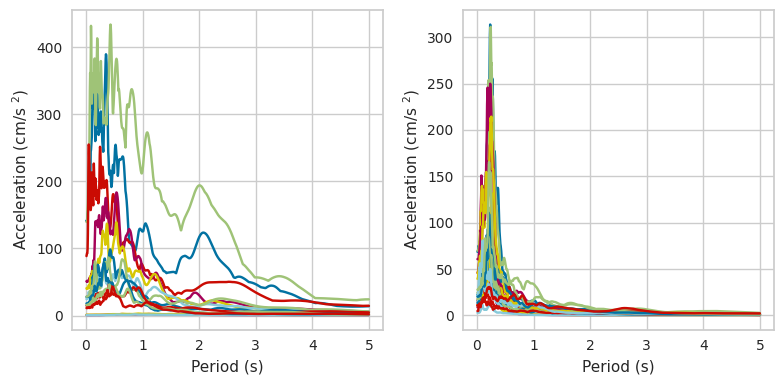

In [265]:
columns = df_psa_merged.columns


fig, axs = plt.subplots(1, 2, figsize=(8,4))

indexs_station = []

for i in range(len(columns)):
  actual_station_key = columns[i][:4]
  if actual_station_key == 'CALE':
    indexs_station.append(i)

print(indexs_station)

axs[0].plot(df_psa_merged['period'].values, df_psa_merged.iloc[:, indexs_station].values)
axs[0].set_xlabel('Period (s)')
axs[0].set_ylabel('Acceleration (cm/s $^2$)')

indexs_station = []


for i in range(len(columns)):
  actual_station_key = columns[i][:4]
  if actual_station_key == 'ACAD':
    indexs_station.append(i)

axs[1].plot(df_psa_merged['period'], df_psa_merged.iloc[:, indexs_station])
axs[1].set_xlabel('Period (s)')
axs[1].set_ylabel('Acceleration (cm/s $^2$)')

plt.tight_layout()

plt.show()

# Preprocessing

## Remove outliers

In [266]:
selected_atributes = ['magnitude', 'calculated_epicentral_distance', 'peak_ground_acceleration']

selected_atributes_large = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'peak_ground_acceleration', 'source_off_shore',
             'calculated_azimuth']


clf = LocalOutlierFactor(contamination=0.001, n_neighbors=200)

scaler = StandardScaler()
outliers_classess = clf.fit_predict(scaler.fit_transform(df[selected_atributes_large]))


In [267]:
outliers = np.where(outliers_classess == -1)
print(outliers)
print(len(outliers[0]))

(array([464, 906]),)
2


In [268]:
outliers = outliers[0]

In [269]:
df[['date','station_key'] + selected_atributes_large].iloc[outliers]

,date,station_key,magnitude,calculated_epicentral_distance,depth,calculated_incidence_angle,calculated_hypocentral_distance,peak_ground_acceleration,source_off_shore,calculated_azimuth
464,1985-09-21,PARS,7.6,164.676001,17.0,5.893938,165.551156,625.78,False,108.760233
906,2012-03-20,SJLL,7.4,43.806051,16.0,20.064536,46.636575,1073.51,True,-5.795153


In [270]:
selected_outliers = [464, 906]

In [271]:
selected_outliers

[464, 906]

In [272]:
df = df.query('index not in @selected_outliers')

In [273]:
df.shape

(1612, 28)

In [274]:
df.reset_index(inplace=True, drop=True)

In [275]:
df.index

RangeIndex(start=0, stop=1612, step=1)

In [276]:
df.head()

,date,time,magnitude,institution,entity,station_key,station_name,peak_ground_acceleration,quality,file,...,duration,incidence_angle,hypocentral_distance,azimuth,angle_to_the_nearest_horizontal_sensor,calculated_epicentral_distance,calculated_hypocentral_distance,calculated_incidence_angle,source_off_shore,calculated_azimuth
0,2018-02-16,23:39:39,7.2,I de I-UNAM,GRO,SLU2,SAN LUIS DE LA LOMA 2,2.94,A,SLU21802.161,...,133.0,2.750835,333.384163,109.987575,21.215506,333.015189,333.399334,2.750710,False,-68.901392
1,2018-02-16,23:39:39,7.2,I de I-UNAM,OAX,SMLC,SAN MARTIN LOS CANSECO,23.38,A,SMLC1802.161,...,210.0,6.296819,145.880088,251.209162,19.712860,145.432447,146.309933,6.278245,False,70.398457
2,2018-02-16,23:39:39,7.2,I de I-UNAM,MIC,SNJE,SAN JERONIMO,3.51,A,SNJE1802.161,...,157.0,2.106481,435.294153,124.990997,36.743086,435.294924,435.588879,2.105055,False,-53.423946
3,2018-02-16,23:39:39,7.2,I de I-UNAM,VER,SODO,SOLEDAD DE DOBLADO,8.76,A,SODO1802.161,...,270.0,2.580599,355.360380,209.494929,28.090209,355.845160,356.204686,2.574478,False,28.236455
4,2018-02-16,23:39:39,7.2,I de I-UNAM,GRO,SUCH,EL SUCHIL,4.41,A,SUCH1802.161,...,138.0,3.042759,301.424949,111.011136,22.227069,301.327132,301.751621,3.039462,False,-67.894639


## Feature engineering

<Axes: xlabel='incidence_angle', ylabel='Count'>

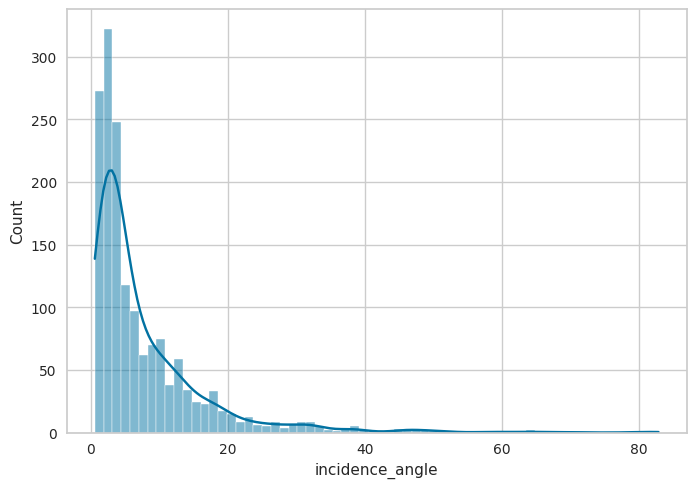

In [277]:
sns.histplot(x=df.incidence_angle, kde=True)

In [278]:
df = df.assign(log_incidence_angle=np.log(df.calculated_incidence_angle))

[Text(0.5, 0, 'Log Incidence Angle')]

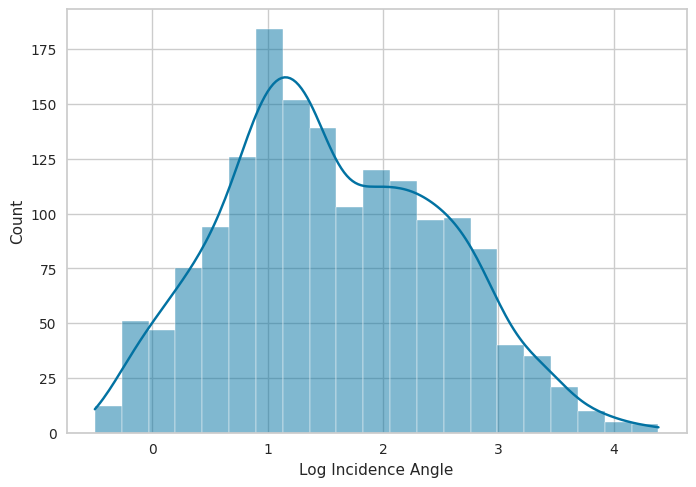

In [279]:
ax = sns.histplot(x=df.log_incidence_angle, kde=True)
ax.set(xlabel='Log Incidence Angle')

<Axes: xlabel='magnitude', ylabel='Count'>

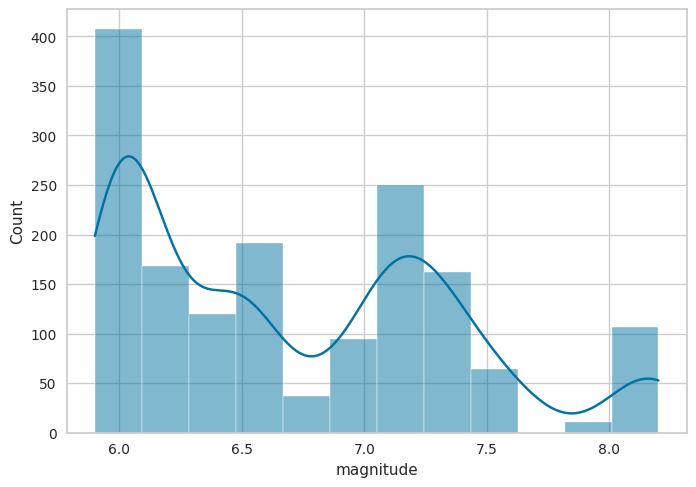

In [280]:
sns.histplot(x=(df.magnitude), kde=True)

[Text(0.5, 0, 'Magnitude Category')]

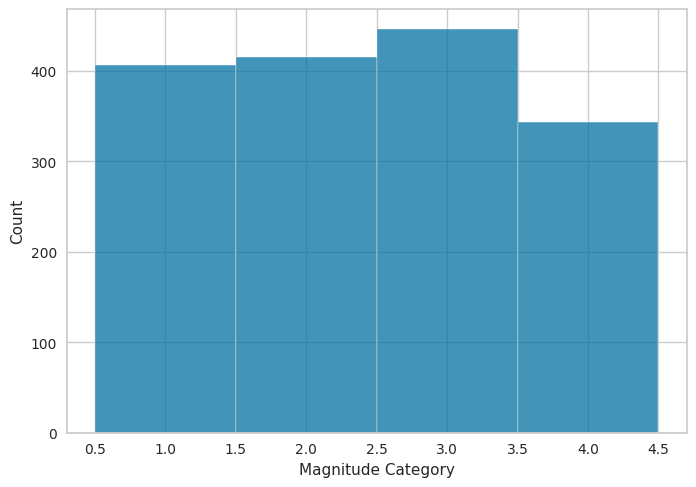

In [281]:
df["magnitude_cat"] = pd.cut(df["magnitude"],
                             bins=[0., 6.08, 6.5, 7.2, np.inf],
                             #bins=[0., 6.04, 6.3, 6.7, 7.2, np.inf],
                             labels=[1, 2, 3, 4, ])

ax = sns.histplot(x=(df.magnitude_cat))

ax.set(xlabel='Magnitude Category')

In [282]:
df["magnitude_cat"].value_counts()

,count
magnitude_cat,
3,446
2,415
1,407
4,344


<Axes: xlabel='peak_ground_acceleration', ylabel='Count'>

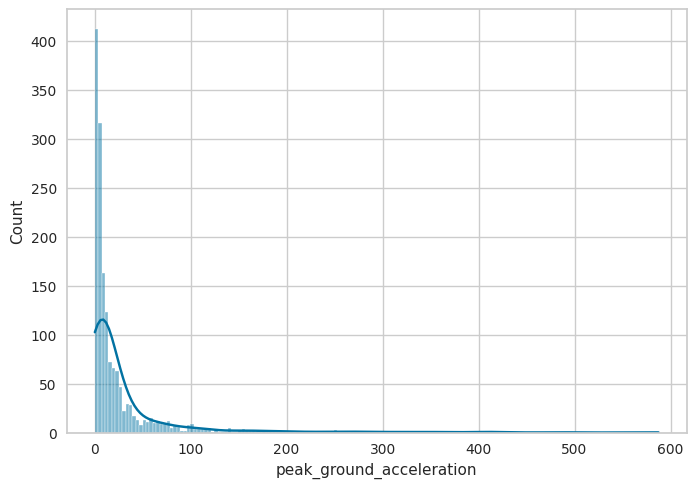

In [283]:
sns.histplot(x=(df.peak_ground_acceleration), kde=True)

In [284]:
df["peak_ground_acceleration_cat"] = pd.cut(df.peak_ground_acceleration,
                                            bins=[0., 2, 4, 6, 10, 18, 30, 80, np.inf],
                                            labels=[1, 2, 3, 4, 5, 6, 7, 8])

<Axes: xlabel='peak_ground_acceleration_cat', ylabel='Count'>

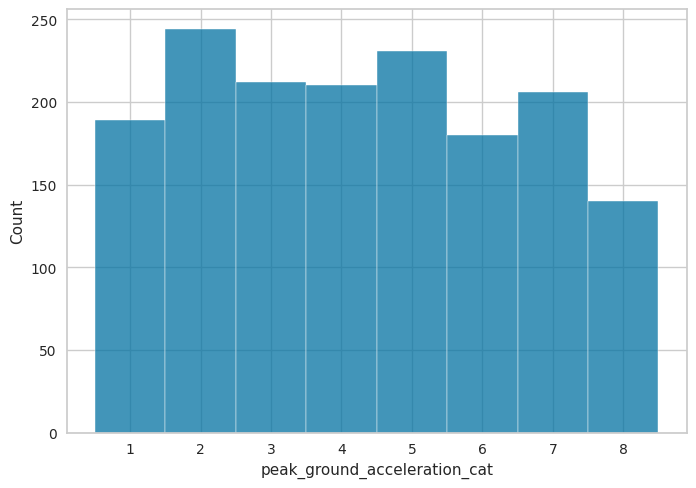

In [285]:
sns.histplot(x=(df.peak_ground_acceleration_cat))

<Axes: xlabel='calculated_epicentral_distance', ylabel='Count'>

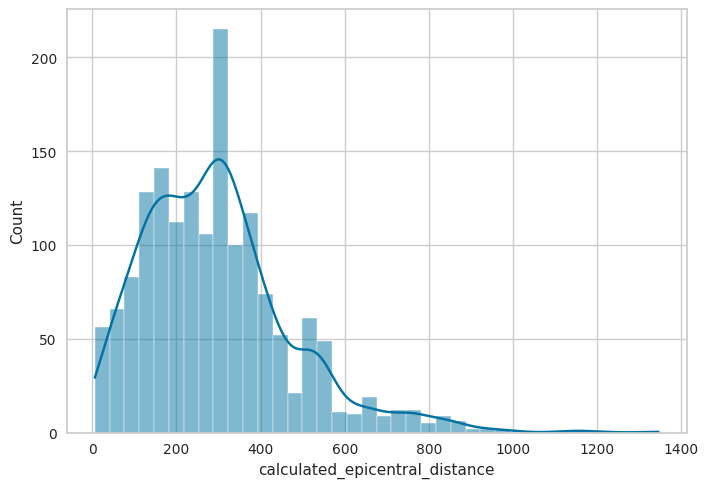

In [286]:
sns.histplot(x=(df.calculated_epicentral_distance), kde=True)

<Axes: xlabel='calculated_epicentral_distance_cat', ylabel='Count'>

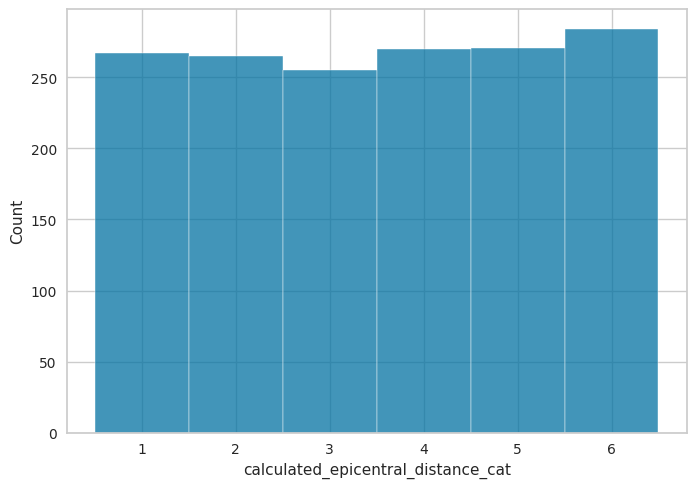

In [287]:
df["calculated_epicentral_distance_cat"] = pd.cut(df.calculated_epicentral_distance,
                                                  bins=[0., 130, 200, 280, 330, 430, np.inf],
                                                  labels=[1, 2, 3, 4, 5, 6])
sns.histplot(x=(df.calculated_epicentral_distance_cat))

<Axes: xlabel='depth', ylabel='Count'>

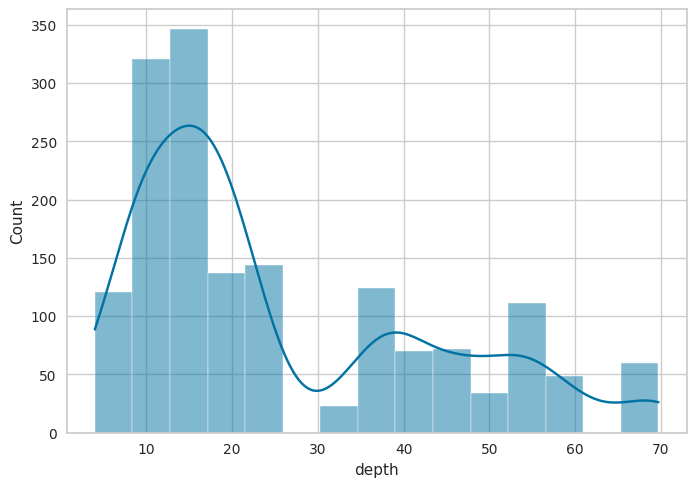

In [288]:
sns.histplot(x=(df.depth), kde=True)

<Axes: xlabel='depth_cat', ylabel='Count'>

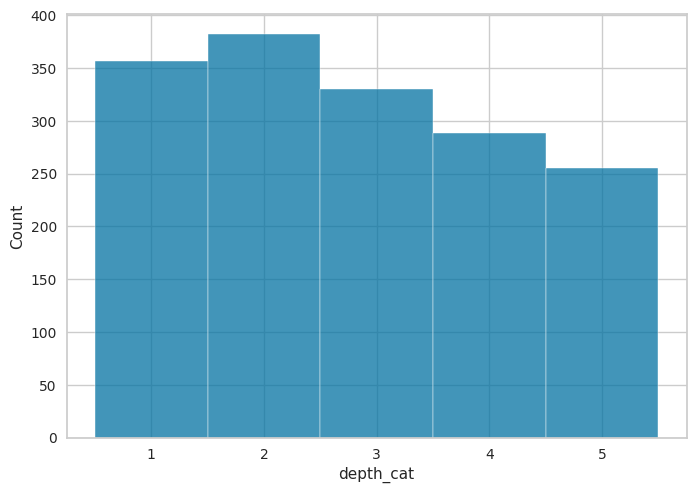

In [289]:
df["depth_cat"] = pd.cut(df.depth,
                         bins=[0., 10, 16, 30, 46, np.inf],
                         labels=[1, 2, 3, 4, 5])
sns.histplot(x=(df.depth_cat))

## PSA preprocessing

In [290]:
print(len(station_keys_set))

148


In [291]:
df_psa_merged.shape

(1000, 1653)

In [292]:
def media_geometrica_arrays(array1, array2):
    # Multiplica os arrays elemento por elemento
    produto = array1 * array2

    # Calcula a raiz quadrada (para dois arrays) de cada elemento
    return np.sqrt(produto)

In [293]:
columns = df_psa_merged.columns

df_merge_spectral_coefs_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_spectral_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_horiz_spectral_mean = pd.DataFrame(columns=list(station_keys_set))
df_merge_vertical_spectral_mean = pd.DataFrame(columns=list(station_keys_set))
#df_merge_hvsr_mean = pd.DataFrame(columns=list(station_keys_set))


station_key_index=0
psa_samples = np.zeros(len(station_keys_set)) # total samples per stations
for station_key in station_keys_set:
  indexs_station_v = []
  indexs_station_ew = []
  indexs_station_ns = []
  v_signals = []
  ew_signals = []
  ns_signals = []
  for i in range(len(columns)):
    actual_station_key = columns[i][:4]
    orientation = columns[i].split("-")[-1]
    if actual_station_key == station_key:
      psa_samples[station_key_index] = psa_samples[station_key_index] + 1
      if orientation == 'V':
        indexs_station_v.append(i)
        v_signals.append(df_psa_merged.iloc[:, i].values)
      elif orientation == 'EW':
        indexs_station_ew.append(i)
        ew_signals.append(df_psa_merged.iloc[:, i].values)
      elif orientation == 'NS':
        indexs_station_ns.append(i)
        ns_signals.append(df_psa_merged.iloc[:, i].values)
      else:
        print('unknown orientation')
  station_key_index +=1

  v_mean = np.mean(v_signals, axis=0)
  ew_mean = np.mean(ew_signals, axis=0)
  ns_mean = np.mean(ns_signals, axis=0)
  ew_v_spectral_coeficients = ew_mean / v_mean
  ns_v_spectral_coeficients = ns_mean / v_mean
  spectral_coefs_mean = np.mean(np.array([ew_v_spectral_coeficients, ns_v_spectral_coeficients]), axis=0)
  df_merge_spectral_coefs_mean[station_key]=spectral_coefs_mean

  spectral_means = np.mean(np.array([v_mean, ew_mean, ns_mean]), axis=0)
  df_merge_spectral_mean[station_key]=spectral_means

  h_spectral_means = np.mean(np.array([ew_mean, ns_mean]), axis=0)
  df_merge_horiz_spectral_mean[station_key]=h_spectral_means

  df_merge_vertical_spectral_mean[station_key]=v_mean

  #h_geomean = media_geometrica_arrays(ew_mean, ns_mean)
  #hvsr = h_geomean / v_mean
  #df_merge_hvsr_mean[station_key]=hvsr



In [294]:
psa_samples

array([ 3.,  3.,  3.,  3.,  3.,  6.,  3.,  6., 12.,  9., 15.,  5.,  6.,
        9., 24.,  9.,  6.,  9.,  6.,  9., 12.,  6., 21.,  3.,  3., 15.,
       15.,  6.,  3., 15., 15., 15., 15., 12., 18.,  3.,  6., 18., 18.,
       12.,  3., 30., 27.,  3.,  6.,  9., 12., 12.,  6.,  9., 12., 15.,
       12.,  3.,  6.,  6., 12., 27., 12., 27.,  3.,  6.,  3., 15.,  6.,
        6., 15.,  6.,  3.,  6., 12., 21., 27., 21., 12., 12., 12.,  3.,
        3., 12.,  6., 12.,  9.,  6.,  3., 12., 15., 12., 21.,  3., 27.,
        9.,  3., 24., 15.,  6., 15.,  9.,  6.,  3., 18.,  6.,  3.,  9.,
        6., 18., 15.,  3.,  3., 21.,  3., 27., 21.,  6.,  6., 15., 21.,
        3.,  6., 12.,  9., 12., 12.,  3., 15., 18.,  6., 12.,  3., 15.,
       21., 18.,  9., 21., 18., 27., 15., 24.,  3., 24.,  6., 27., 12.,
        9., 15., 12., 12.,  3.])

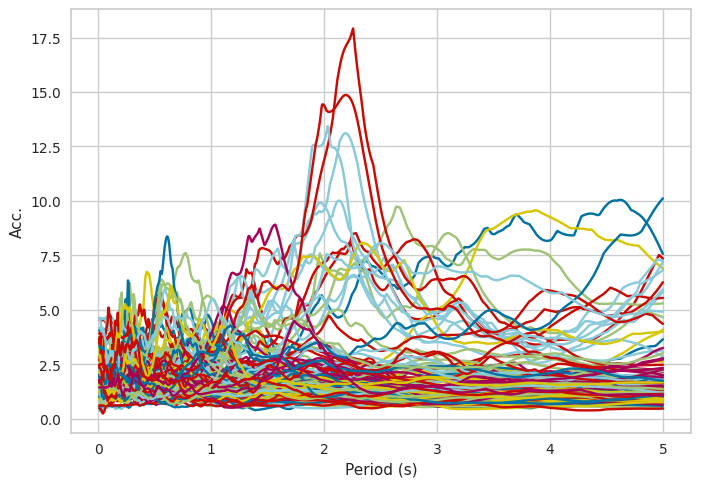

In [295]:

plt.plot(df_psa_merged['period'].values, df_merge_spectral_coefs_mean.values)
plt.xlabel('Period (s)')
plt.ylabel('Acc.')
plt.show()


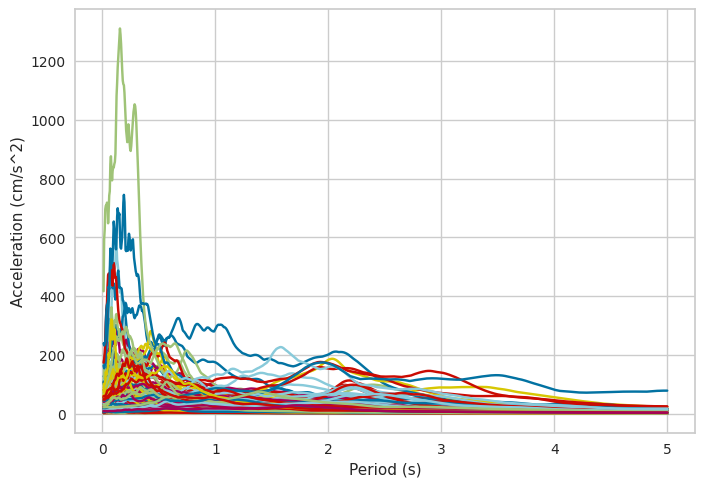

In [296]:
plt.plot(df_psa_merged['period'].values, df_merge_spectral_mean.values)

plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

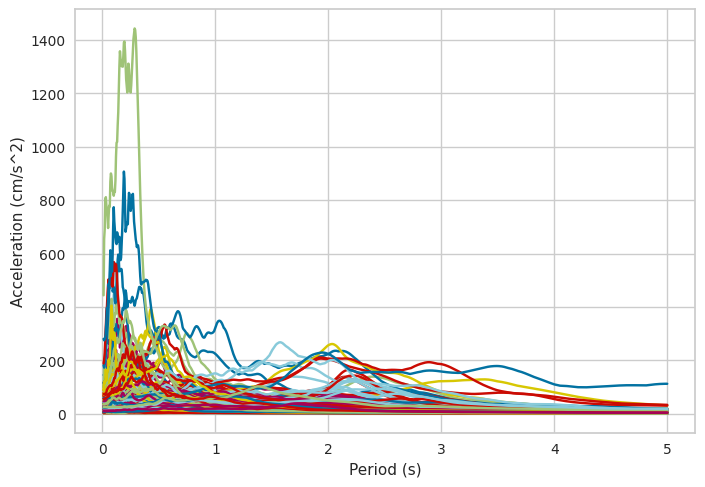

In [297]:
plt.plot(df_psa_merged['period'].values, df_merge_horiz_spectral_mean.values)


plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

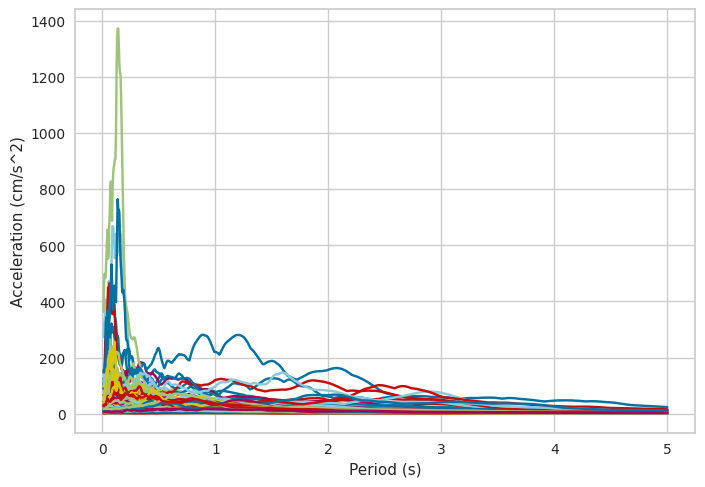

In [298]:
plt.plot(df_psa_merged['period'].values, df_merge_vertical_spectral_mean.values)

plt.xlabel('Period (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.show()

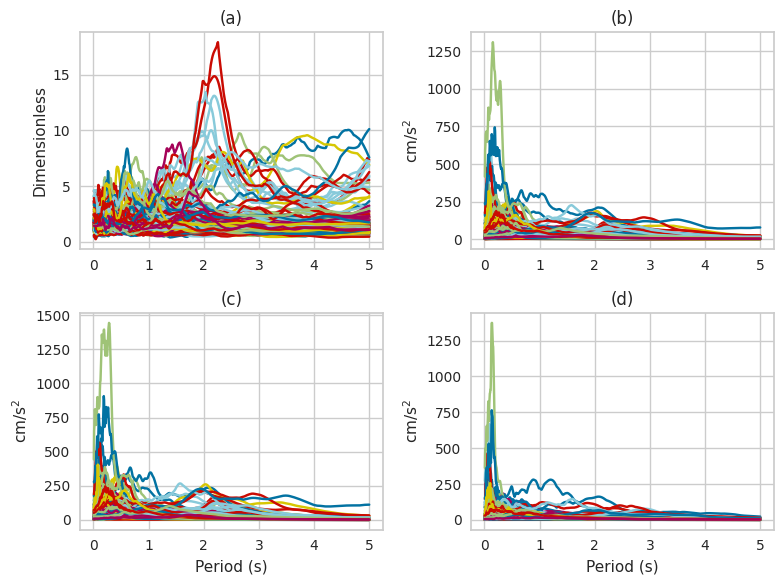

In [299]:
#Figure: a) Spectral Ratio, b) Three Axis Spectra c) Horizontal Spectral d) Vertical Spectra

fig, axs = plt.subplots(2, 2, figsize=(8,6))
axs[0,0].plot(df_psa_merged['period'].values, df_merge_spectral_coefs_mean.values)
axs[0,0].set_ylabel('Dimensionless')
axs[0,0].set_title('(a)')

axs[0,1].plot(df_psa_merged['period'].values, df_merge_spectral_mean.values)
axs[0,1].set_ylabel('cm/s$^2$')
axs[0,1].set_title('(b)')

axs[1, 0].plot(df_psa_merged['period'].values, df_merge_horiz_spectral_mean.values)
axs[1, 0].set_xlabel('Period (s)')
axs[1, 0].set_ylabel('cm/s$^2$')
axs[1, 0].set_title('(c)')

axs[1, 1].plot(df_psa_merged['period'].values, df_merge_vertical_spectral_mean.values)
axs[1, 1].set_xlabel('Period (s)')
axs[1, 1].set_ylabel('cm/s$^2$')
axs[1, 1].set_title('(d)')

plt.tight_layout()

plt.show()

Figure: a) Spectral Ratio, b) Three Axis Spectra c) Horizontal Spectral d) Vertical Spectra

## Clustering

In [300]:
df.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat'],
      dtype='object')

### spectral coefs

In [301]:
X=df_merge_spectral_coefs_mean.T.copy().values

In [302]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

In [303]:
scores = []
for i in range(2, 8):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(Xscaled)
  scores.append(kmeans.inertia_)

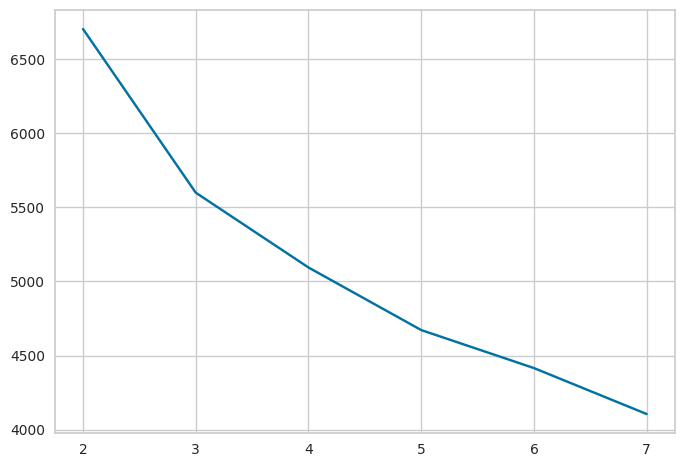

In [304]:
plt.plot(range(2,8), scores)

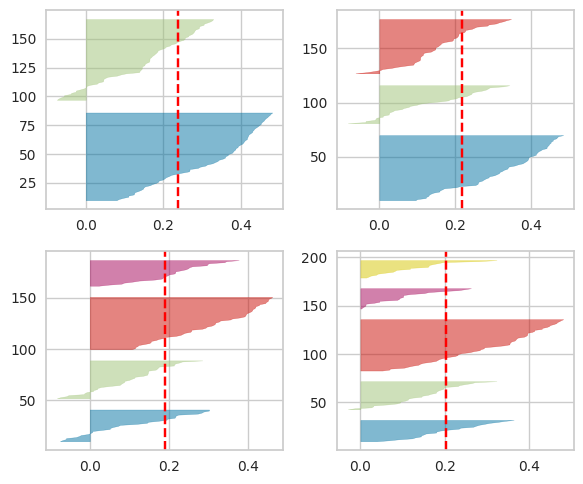

In [305]:
fig, ax = plt.subplots(2, 2, figsize=(6,5))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

plt.tight_layout()
plt.show()

In [306]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [307]:
labels_kmeans_spectral_coefs_mean = kmeans.labels_

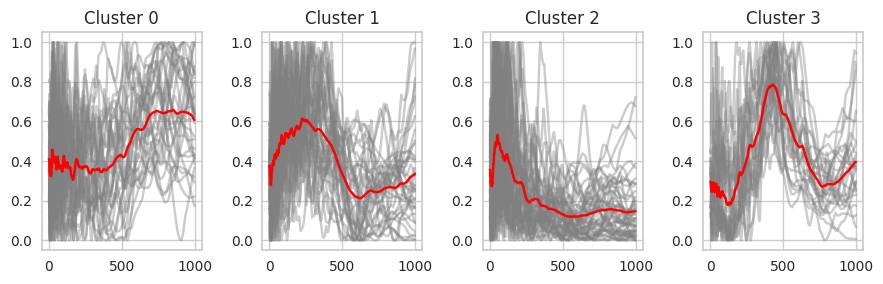

In [308]:
fig, axs = plt.subplots(1, k, figsize=(9,3))
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_coefs_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_coefs_mean)):
      if(labels_kmeans_spectral_coefs_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1


plt.tight_layout()
plt.show()

In [309]:
clusters_kmeans_spectral_coefs_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_coefs_mean))

### spectral mean

In [310]:
X=df_merge_spectral_mean.T.copy().values

In [311]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

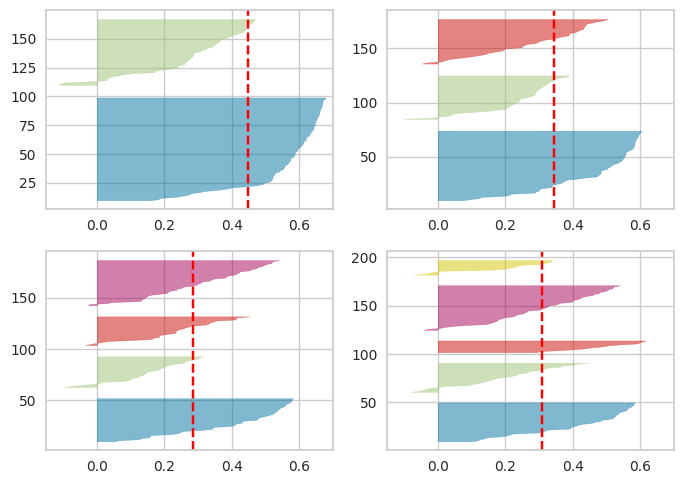

In [312]:
fig, ax = plt.subplots(2, 2, figsize=(7,5))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    axe = ax[q-1][mod]
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=axe)
    visualizer.fit(Xscaled)
    axe.set_xlim([-0.15, 0.7])

plt.tight_layout()
plt.show()

In [313]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [314]:
labels_kmeans_spectral_mean = kmeans.labels_

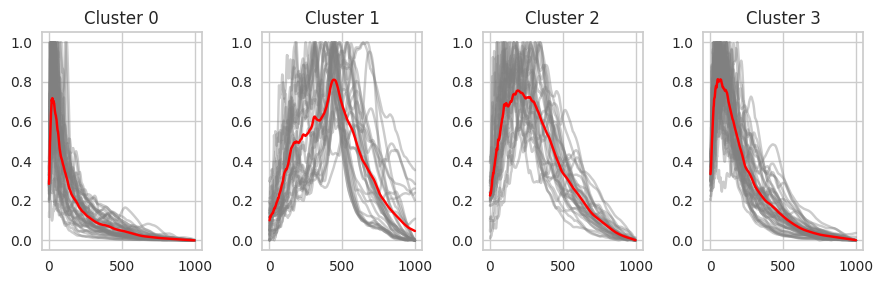

In [315]:
fig, axs = plt.subplots(1, k, figsize=(9,3))
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_mean)):
      if(labels_kmeans_spectral_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1


plt.tight_layout()
plt.show()

In [316]:
clusters_kmeans_spectral_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_mean))

### spectral horizontal mean

In [317]:
X=df_merge_horiz_spectral_mean.T.copy().values

In [318]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

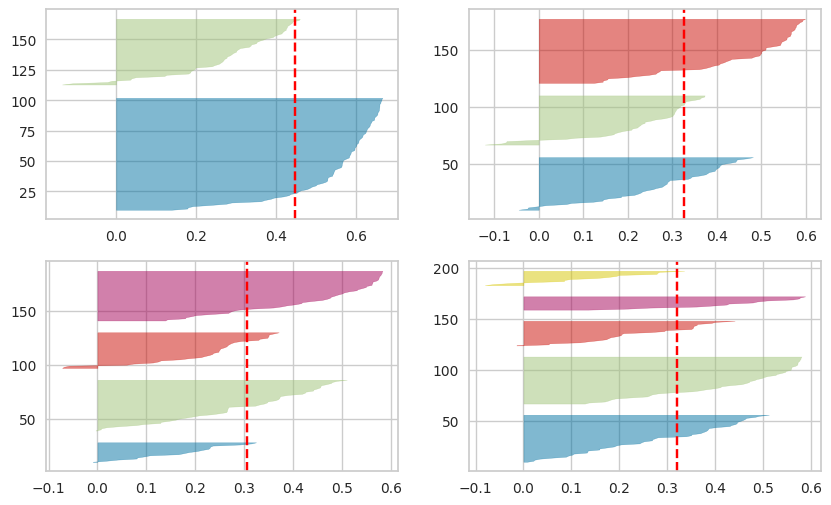

In [319]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [320]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [321]:
labels_kmeans_spectral_horiz_mean = kmeans.labels_

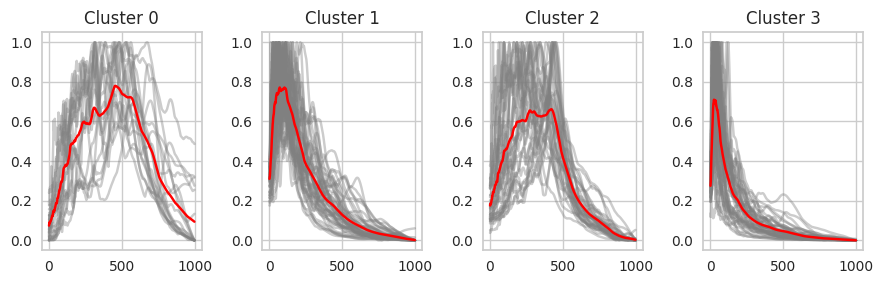

In [322]:
fig, axs = plt.subplots(1, k, figsize=(9,3))
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_horiz_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_horiz_mean)):
      if(labels_kmeans_spectral_horiz_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1


plt.tight_layout()
plt.show()

In [323]:
clusters_kmeans_spectral_horiz_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_horiz_mean))

### spectral vertical mean

In [324]:
X=df_merge_vertical_spectral_mean.T.copy().values

In [325]:
Xscaled=X.copy()

for i in range(len(X)):
    scaler = MinMaxScaler()
    Xscaled[i] = MinMaxScaler().fit_transform(X[i].reshape(-1,1)).reshape(len(X[i]))

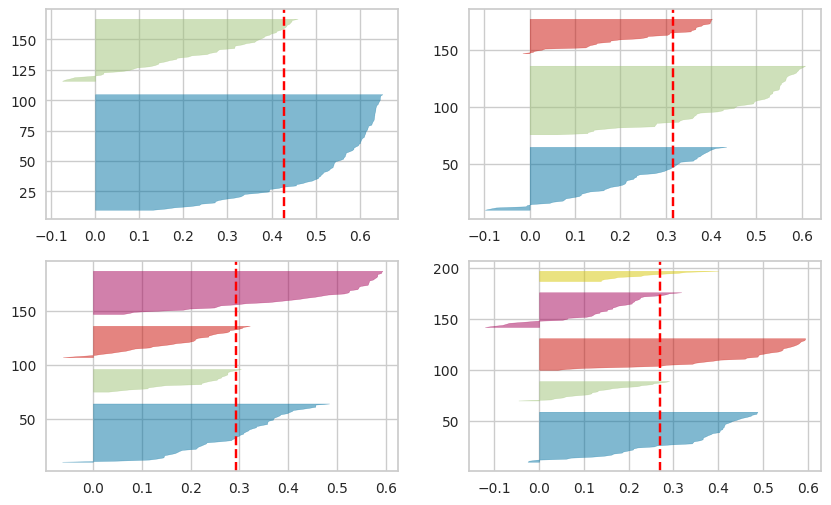

In [326]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Xscaled)

In [327]:
k=4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xscaled)

In [328]:
labels_kmeans_spectral_vert_mean = kmeans.labels_

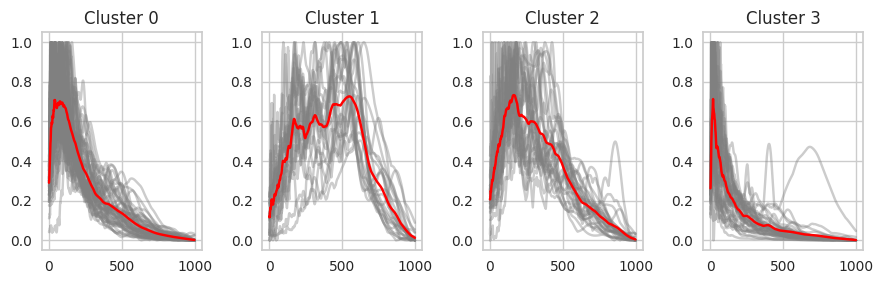

In [329]:
fig, axs = plt.subplots(1, k, figsize=(9,3))
row_i=0
column_j=0

# For each label there is,
# plots every series with that label
for label in set(labels_kmeans_spectral_vert_mean):
    cluster = []
    for i in range(len(labels_kmeans_spectral_vert_mean)):
      if(labels_kmeans_spectral_vert_mean[i]==label):
          axs[column_j].plot(Xscaled[i], c="gray", alpha=0.4)
          cluster.append(Xscaled[i])
    if len(cluster) > 0:
        axs[column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[column_j].set_title("Cluster "+str(label))
    column_j+=1


plt.tight_layout()
plt.show()

In [330]:
clusters_kmeans_spectral_vert_mean_dict = dict(zip(station_keys_set, labels_kmeans_spectral_vert_mean))

## Add cluster column

In [331]:
def add_clusters(df, clusters_dict, cluster_column_name):
  lost_stations = []
  df_com_clusters = df.copy()

  for index, row in df_com_clusters.iterrows():
    station_key = df_com_clusters['station_key'].iloc[index]
    try:
      df_com_clusters.at[index, cluster_column_name] = clusters_dict[station_key]
    except:
      lost_stations.append(station_key)
  return df_com_clusters, lost_stations

In [332]:
df_com_clusters, lost_stations = add_clusters(df, clusters_kmeans_spectral_coefs_mean_dict, 'clusters_spectral_coefs')

In [333]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_mean_dict, 'clusters_spectral_means')

In [334]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_horiz_mean_dict, 'clusters_spectral_horiz_means')

In [335]:
df_com_clusters, lost_stations = add_clusters(df_com_clusters, clusters_kmeans_spectral_vert_mean_dict, 'clusters_spectral_vert_means')

In [336]:
df_com_clusters.clusters_spectral_means.value_counts()

,count
clusters_spectral_means,
3.0,568
0.0,520
2.0,322
1.0,202


/tmp/ipython-input-433548499.py:14: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  g = sns.scatterplot(ax=ax1,


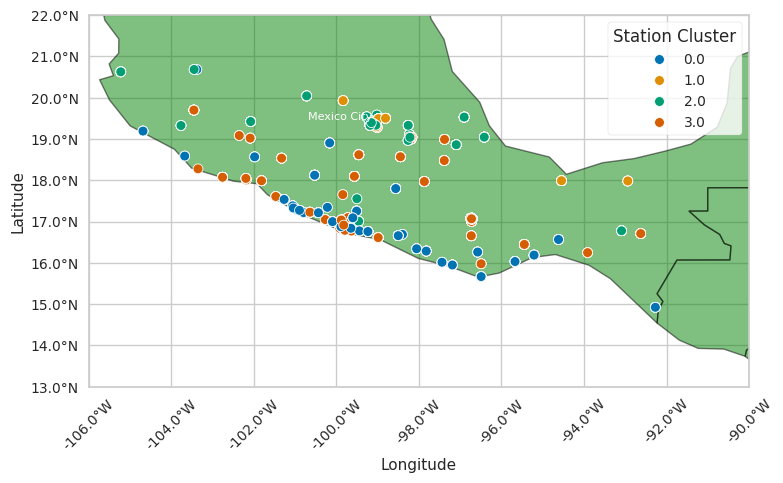

In [337]:
#ax1 = map.plot(figsize=(8,6), alpha=0.5)

# Faça o plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plote o contorno do México
world.plot(ax=ax1, edgecolor='black', facecolor='green', linewidth=1, zorder=1, alpha=0.5)

# Adicionar marcadores para cada localização
for lon, lat, name in locations:
    ax1.plot(lon, lat, 'ko', markersize=3)
    ax1.text(lon, lat, name, color='w', fontsize=8, ha='right', va='bottom')

g = sns.scatterplot(ax=ax1,
                data=df_com_clusters,
                x='station_longitude',
                y='station_latitude',
                #size='clusters_spectral_means',
                hue='clusters_spectral_means',
                #sizes=(20, 200),
                #marker=(8,1,0),
                s=50,
                zorder=2,
                palette=sns.color_palette('colorblind'))

#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(frameon=True, title='Station Cluster')

ax1.set(xlabel='Longitude', ylabel='Latitude')
plt.xlim([-106, -90])
plt.ylim([13, 22])

# Definir intervalos para os ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Intervalo de 2 graus
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Intervalo de 1 grau

# Formatar os labels com o símbolo de grau
def longitude_formatter(x, p):
    return f'{x}°W'

def latitude_formatter(x, p):
    return f'{x}°N'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(longitude_formatter))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(latitude_formatter))

# Rotacionar os labels do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Ajustar o layout para evitar cortes
plt.tight_layout()


plt.show()

##Split

In [338]:
df_com_clusters.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [339]:
strat_column="magnitude_cat"

In [340]:
df_com_clusters.shape

(1612, 37)

In [341]:
train_set, test_set = train_test_split(
    df_com_clusters, test_size=0.2, stratify=df_com_clusters[strat_column], random_state=42)

In [342]:
train_set.shape

(1289, 37)

In [343]:
test_set.shape

(323, 37)

In [344]:
test_set[strat_column].value_counts() / len(test_set)

,count
magnitude_cat,
3,0.275542
2,0.256966
1,0.253870
4,0.213622


Split for Neural Network

In [345]:
X_train, X_valid, y_train, y_valid = train_test_split(train_set, train_set.peak_ground_acceleration, test_size=0.2, random_state=42, stratify=train_set[strat_column]) #for DNN


# Machine Learning Regression

## hiperparameters tuning

In [346]:
num_attributes = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'calculated_azimuth', 'source_off_shore', 'log_incidence_angle']

num_pipeline = Pipeline([
  ("standardize", StandardScaler()),
])

clusters_spectral_means selected to hiperparameters tuning

In [347]:
selected_cluster_column = 'clusters_spectral_means'


In [348]:
cat_attribs = [selected_cluster_column]


cat_pipeline = make_pipeline(
  SimpleImputer(strategy="most_frequent"),
  OneHotEncoder(handle_unknown="ignore"))


preprocessor = ColumnTransformer([
  ("cat", cat_pipeline, cat_attribs),
  ('num', num_pipeline, num_attributes)
  ], remainder="drop")

### Random Forest Grid Search

In [349]:
steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
]

pipeline = Pipeline(steps)

In [350]:
param_grid = [
    {'model__n_estimators': [300, 500, 700, 900, 1200, 1500, 1800, 2100],
     'model__max_features': [0.3, 0.2, 0.1],
  }]


grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=False,
                           verbose=2)


In [351]:
if hiperparameters_tuning:
  grid_search.fit(train_set, train_set['peak_ground_acceleration'])

  print(grid_search.best_params_)
  print(np.sqrt(-grid_search.best_score_))
  best_grid = grid_search.best_estimator_
  pred = best_grid.predict(test_set)
  rmse = mean_squared_error(test_set['peak_ground_acceleration'], pred, squared=False)
  print(rmse)
  print(best_grid['model'].feature_importances_)

#### Optuna

In [352]:
#hiperparameters_tuning = True

In [353]:
if hiperparameters_tuning:
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'random_state': 42,
            'n_jobs': -1
        }

        X_train_processed = preprocessor.fit_transform(train_set)
        y_train = train_set['peak_ground_acceleration']

        # Instanciando o RandomForestRegressor
        reg = RandomForestRegressor(**param)

        # Validação cruzada
        kfold = KFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(reg, X_train_processed, y_train,
                                cv=kfold,
                                scoring='neg_mean_squared_error').mean()

        return score

    # Criação e execução do estudo do Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=300)

    print("Melhores hiperparâmetros: ", study.best_params)
    print("Melhor score (neg_mean_squared_error): ", study.best_value)

### Neural network keras tuner

In [354]:
def build_model(hp):
  n_hidden = hp.Int("n_hidden", min_value=2, max_value=11, default=2)
  n_neurons = hp.Int("n_neurons", min_value=100, max_value=1800)
  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                           sampling="log")
  optimizer = hp.Choice("optimizer", values=["adam", 'nesterov'])
  activation_function = hp.Choice("activation", values=["relu", "swish"])

  if optimizer == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == "nesterov":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, nesterov=True, momentum=0.9)
  elif optimizer == "adamw":
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())

  for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=activation_function, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1))
  model.compile(loss="huber",  #loss="mse",
                optimizer=optimizer,
                metrics=["RootMeanSquaredError"])
  return model

In [355]:
tf_x_train = preprocessor.fit_transform(X_train)
tf_x_valid = preprocessor.transform(X_valid)

In [356]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_root_mean_squared_error", direction="min"),
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='keras_tuner',
                     seed=42,
                     overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [357]:
if hiperparameters_tuning:
  tuner.search(tf_x_train, y_train, validation_data=(tf_x_valid, y_valid), callbacks=[stop_early], verbose=2)
  best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
  print(best_trial.summary())

Trial 0081 summary
Hyperparameters:
n_hidden: 10
n_neurons: 687
learning_rate: 0.0015141913494764387
optimizer: nesterov
activation: relu
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 39.60440444946289

### XGboost

In [358]:
[x for x in range(100, 1100, 300)]

[100, 400, 700, 1000]

In [359]:
#hiperparameters_tuning = True

In [360]:
if hiperparameters_tuning:
  xgb_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('regressor', xgb.XGBRegressor(random_state=42))
  ])


  param_grid = {
      'regressor__n_estimators': range(100, 1001, 2100), #[100, 300, 600, 900],
      'regressor__max_depth': range(4, 8, 1), #[4, 5, 6, 7],
      'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
      'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
      #'regressor__min_child_weight': range(0, 4, 1),
      #'regressor__gamma': range(0, 4, 1),
      #'regressor__reg_alpha' :  range(0, 20, 100), #hp.quniform('reg_alpha', 40,180,1),
      #'regressor__reg_lambda' : range(0, 20, 100), #hp.uniform('reg_lambda', 0,1),
  }


  kfold = KFold(n_splits=5, shuffle=True, random_state=42)

  grid_search = GridSearchCV(
      estimator=xgb_pipeline,
      param_grid=param_grid,
      #n_iter=100,
      scoring='neg_mean_squared_error',
      #n_jobs=-1,
      n_jobs=1,
      cv=kfold,
      verbose=10,
      #random_state=42
  )

  grid_search.fit(train_set, train_set['peak_ground_acceleration'])


  print("\n Best hiperparameters:")
  print(grid_search.best_params_)

  print("\nBest score (neg_mean_squared_error):")
  print(grid_search.best_score_)

  best_model = grid_search.best_estimator_



#### Optuna

In [361]:

if hiperparameters_tuning:
  def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2100),
        'learning_rate': trial.suggest_float('learning_rate',  1e-4, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 25),
        'gamma': trial.suggest_float('gamma', 1e-8, 5, log=True),
        #'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1e2),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1e2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    X_train_processed = preprocessor.fit_transform(train_set)
    y_train = train_set['peak_ground_acceleration']

    reg = xgb.XGBRegressor(**param)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(reg, X_train_processed, y_train,
                            cv=kfold, scoring='neg_mean_squared_error').mean()

    return score


  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=300)


  print("Best hiperparameters: ", study.best_params)
  print("Best score (neg_mean_squared_error): ", study.best_value)

## Traning experiments

In [362]:
num_attributes = ['magnitude',
             'calculated_epicentral_distance', 'depth', 'calculated_incidence_angle',
             'calculated_hypocentral_distance', 'calculated_azimuth', 'source_off_shore', 'log_incidence_angle']

num_pipeline = Pipeline([
  ("standardize", StandardScaler()),
])

In [363]:
experiments = {}
trained_pipelines = {}

# RF_max_features=0.1
# RF_n_estimators= 900
# #RF_max_depth=
# #RF_min_samples_split
# #RF_min_samples_leaf
# RF_oob_score=False
# RF_warm_start=False

# RF_max_features=0.8295181197004419
# RF_n_estimators= 589
# RF_max_depth= 23
# RF_min_samples_split = 2
# RF_min_samples_leaf = 3
# RF_oob_score=False
# RF_warm_start=False


RF_n_estimators= 1571
RF_max_depth= 14
RF_min_samples_split = 9
RF_min_samples_leaf = 4
RF_max_features=0.6304629822885958
RF_oob_score=False
RF_warm_start=False

nn_neurons = 1583
nn_hidden_layers = 5
nn_activation = "swish"
nn_learning_rate = 0.0006601146406744397

elasticnet_alpha=0.1
elasticnet_l1_ratio=0.5
elasticnet_max_iter=100000

polynomial_include_bias=True

nn_optimizer = keras.optimizers.SGD(learning_rate=nn_learning_rate, nesterov=True, momentum=0.9)


# xbg_colsample_bytree= 0.8950712208863197
# xbg_max_depth = 7
# xbg_n_estimators = 358
# xbg_subsample = 0.6287944976282687
# xbg_gamma = 2.8845334342509843
# xbg_min_child_weight = 2
# xbg_learning_rate = 0.01349849929832932
# xbg_reg_alpha = 0.840678380595821
# xbg_reg_lambda = 3.9477129819761734


# xbg_n_estimators = 215
# xbg_learning_rate = 0.04801837809067573
# xbg_max_depth = 27
# xbg_subsample = 0.3666717398618287
# xbg_colsample_bytree=  0.8109332690402515
# xbg_min_child_weight = 11
# xbg_gamma = 3.9606653932439215
# xbg_reg_alpha = 0.01466128333556409
# xbg_reg_lambda = 0.4516642359041898


xbg_n_estimators = 261
xbg_learning_rate = 0.039013930308612235
xbg_max_depth = 7
xbg_subsample = 0.3780800417902329
xbg_colsample_bytree=  0.8326213820774643
xbg_min_child_weight = 12
xbg_gamma = 3.8948880142909856
xbg_reg_alpha = 0.05162348742850506
xbg_reg_lambda = 0.5677206268714267



preprocessor = ColumnTransformer([
    ('num',
     num_pipeline,
     num_attributes)
    ], remainder="drop")


In [364]:
def model_experiment(train_set, test_set, pipeline, experiments_dict, experiment_name):

  pipeline.fit(train_set, train_set['peak_ground_acceleration'])

  predictions = pipeline.predict(test_set)
  #test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
  test_rmse = root_mean_squared_error(test_set['peak_ground_acceleration'], predictions)
  r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

  confidence = 0.95
  squared_errors = (predictions - test_set['peak_ground_acceleration']) ** 2
  conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                           loc=squared_errors.mean(),
                           scale=stats.sem(squared_errors)))
  conf_range = conf_interval[1] - conf_interval[0]

  experiments_dict[experiment_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

  return test_rmse, r2, pipeline, experiments_dict

### without clusters

In [365]:
if not load_trained_models:
  steps = [
      ('preprocessor', preprocessor),
      ('model', LinearRegression())
  ]

  pipeline = Pipeline(steps)

  model_name = 'Linear Regression'

  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

  trained_pipelines[model_name] = pipeline


  steps = [
      ('preprocessor', preprocessor),
      ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
      ('model', LinearRegression())
  ]

  pipeline = Pipeline(steps)

  model_name = 'Polynomial Regression'
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

  trained_pipelines[model_name] = pipeline

  steps = [
      ('preprocessor', preprocessor),
      ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
      ('model', ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1_ratio, max_iter=elasticnet_max_iter))
  ]

  pipeline = Pipeline(steps)

  model_name = 'Polynomial ElasticNet'
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

  trained_pipelines[model_name] = pipeline


  steps = [
      ('preprocessor', preprocessor),
      ('model', RandomForestRegressor(max_features=RF_max_features,
                                      n_estimators=RF_n_estimators,
                                      max_depth=RF_max_depth,
                                      min_samples_split=RF_min_samples_split,
                                      min_samples_leaf=RF_min_samples_leaf,
                                      oob_score=RF_oob_score,
                                      warm_start=RF_warm_start,
                                      random_state=42))
  ]


  pipeline = Pipeline(steps)

  model_name = 'Random Forest'
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

  trained_pipelines[model_name] =pipeline





In [366]:
if not load_trained_models:
  #tf.keras.backend.clear_session()

  model = tf.keras.Sequential()

  for _ in range(nn_hidden_layers):
      model.add(tf.keras.layers.Dense(nn_neurons, activation=nn_activation, kernel_initializer="he_normal"))
      model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Dense(1))

  rmse_metric = tf.keras.metrics.RootMeanSquaredError(name='rmse')
  nn_optimizer = keras.optimizers.SGD(learning_rate=nn_learning_rate, nesterov=True, momentum=0.9)
  model.compile(loss="huber",
                optimizer=nn_optimizer,
                metrics=[
                    rmse_metric
                    ])

In [367]:
if not load_trained_models:

  es = EarlyStopping(monitor='val_rmse',
                      mode='min',
                      verbose=1,
                      patience=10,
                      restore_best_weights=True
                      )


  tf_x_train = preprocessor.fit_transform(X_train)
  tf_x_valid = preprocessor.transform(X_valid)

  history = model.fit(tf_x_train, y_train,
                      epochs=100,
                      callbacks=[es],
                      validation_data=(tf_x_valid, y_valid),
                      verbose=1)


  tf_test = preprocessor.transform(test_set)
  predictions = model.predict(tf_test)

  #test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
  test_rmse = root_mean_squared_error(test_set['peak_ground_acceleration'], predictions)
  r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

  confidence = 0.95
  squared_errors = (predictions[:, 0] - test_set['peak_ground_acceleration']) ** 2
  conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                            loc=squared_errors.mean(),
                            scale=stats.sem(squared_errors)))
  conf_range = conf_interval[1] - conf_interval[0]

  model_name = 'Deep Neural Network'
  experiments[model_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

  steps = [
      ('preprocessor', preprocessor),
      ('model', model)
    ]

  pipeline = Pipeline(steps)
  trained_pipelines[model_name] =pipeline

  pd.DataFrame(history.history).plot(
      figsize=(8, 5), grid=True, xlabel="Epoch",
      style=["r--", "r--.", "b-", "b-*"])
  plt.show()

In [368]:
# Add XGBoost model to experiments
model_name = 'XGBoost'
print(model_name)

steps = [
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror',
                               colsample_bytree=xbg_colsample_bytree,
                               learning_rate=xbg_learning_rate,
                               max_depth=xbg_max_depth,
                               n_estimators=xbg_n_estimators,
                               subsample=xbg_subsample,
                               gamma = xbg_gamma,
                               min_child_weight = xbg_min_child_weight,
                               reg_alpha = xbg_reg_alpha,
                               reg_lambda = xbg_reg_lambda,
                               random_state=42)) # Use reg:squarederror for regression
]


pipeline = Pipeline(steps)

test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
trained_pipelines[model_name] = pipeline








XGBoost


In [369]:
trained_pipelines[model_name]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  ['magnitude',
                                                   'calculated_epicentral_distance',
                                                   'depth',
                                                   'calculated_incidence_angle',
                                                   'calculated_hypocentral_distance',
                                                   'calculated_azimuth',
                                                   'source_off_shore',
                                                   'log_incidence_angle'])])),
                ('model',
                 XGBRegressor(base_score=None, booste...
                              gamma=3.8948880142909856, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.039013930308612235, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=12, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=261, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [370]:
# df_experiments = pd.DataFrame(experiments.values())
# df_experiments['Description'] = experiments.keys()
# df_experiments.columns = ['rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ,'Description']
# df_experiments = df_experiments[['Description', 'rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ]]
# df_experiments.sort_values(by='rmse')

### With clusters

In [371]:
cluster_columns = ['clusters_spectral_coefs', 'clusters_spectral_means', 'clusters_spectral_horiz_means', 'clusters_spectral_vert_means']

In [372]:
history_dnn = {}

In [373]:
def criar_modelo_dnn(nn_hidden_layers, nn_neurons, nn_activation, nn_optimizer):
    model = Sequential()
    for _ in range(nn_hidden_layers):
        model.add(Dense(nn_neurons, activation=nn_activation, kernel_initializer="he_normal"))
        model.add(BatchNormalization())
    model.add(Dense(1))

    rmse_metric = tf.keras.metrics.RootMeanSquaredError(name='rmse')

    model.compile(loss="huber",
                  optimizer=nn_optimizer,
                  metrics=[rmse_metric])

    return model

In [374]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


if not load_trained_models:
  for selected_cluster_column in cluster_columns:
    print(selected_cluster_column)

    cat_attribs = [selected_cluster_column]

    preprocessor_with_psa_cluster = ColumnTransformer([
      ("cat", cat_pipeline, cat_attribs),
      ('num', num_pipeline, num_attributes)
      ], remainder="drop")


    model_name = f'Linear Regression with PSA {selected_cluster_column}'
    print(model_name)
    steps = [
      ('preprocessor', preprocessor_with_psa_cluster),
      ('model', LinearRegression())
    ]

    pipeline = Pipeline(steps)

    test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
    trained_pipelines[model_name] = pipeline


    model_name = f'Polynomial Regression with PSA {selected_cluster_column}'
    print(model_name)

    steps = [
        ('preprocessor', preprocessor_with_psa_cluster),
        ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
        ('model', LinearRegression())
    ]

    pipeline = Pipeline(steps)

    test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
    trained_pipelines[model_name] = pipeline


    model_name = f'Polynomial ElasticNet with PSA {selected_cluster_column}'
    print(model_name)

    steps = [
      ('preprocessor', preprocessor_with_psa_cluster),
      ('poly', PolynomialFeatures(degree=2, include_bias=polynomial_include_bias)),
      ('model', ElasticNet(alpha=elasticnet_alpha, l1_ratio=elasticnet_l1_ratio, max_iter=elasticnet_max_iter))
    ]

    pipeline = Pipeline(steps)
    test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)

    trained_pipelines[model_name] = pipeline


    model_name = f'Random Forest with PSA {selected_cluster_column}'
    print(model_name)

    steps = [
      ('preprocessor', preprocessor_with_psa_cluster),
      ('model', RandomForestRegressor(max_features=RF_max_features,
                                      n_estimators=RF_n_estimators,
                                      max_depth=RF_max_depth,
                                      min_samples_split=RF_min_samples_split,
                                      min_samples_leaf=RF_min_samples_leaf,
                                      oob_score=RF_oob_score,
                                      warm_start=RF_warm_start,
                                      random_state=42))
    ]

    pipeline = Pipeline(steps)
    test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
    trained_pipelines[model_name] = pipeline


    # model_name = f'Deep Neural Network with PSA {selected_cluster_column}'
    # print(model_name)

    # tf.keras.backend.clear_session()

    # nn_optimizer = keras.optimizers.SGD(learning_rate=nn_learning_rate, nesterov=True, momentum=0.9)
    # model = criar_modelo_dnn(nn_hidden_layers, nn_neurons, nn_activation, nn_optimizer)

    # es = EarlyStopping(monitor='val_rmse',
    #                     mode='min',
    #                     verbose=1,
    #                     patience=10,
    #                     restore_best_weights=True
    #                     )

    # tf_x_train = preprocessor_with_psa_cluster.fit_transform(X_train)
    # tf_x_valid = preprocessor_with_psa_cluster.transform(X_valid)

    # #tf.config.run_functions_eagerly(True)
    # tf.data.experimental.enable_debug_mode()
    # history = model.fit(tf_x_train, y_train,
    #                     epochs=50, callbacks=[es],
    #                     validation_data=(tf_x_valid, y_valid))
    # history_dnn[model_name] = history


    # steps = [
    #   ('preprocessor', preprocessor_with_psa_cluster),
    #   ('model', model)
    # ]
    # pipeline = Pipeline(steps)

    # predictions = pipeline.predict(test_set)
    # #test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
    # test_rmse = root_mean_squared_error(test_set['peak_ground_acceleration'], predictions)
    # r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

    # confidence = 0.95
    # squared_errors = (predictions[:, 0] - test_set['peak_ground_acceleration']) ** 2
    # conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    #                           loc=squared_errors.mean(),
    #                           scale=stats.sem(squared_errors)))
    # conf_range = conf_interval[1] - conf_interval[0]


    # experiments[model_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

    # trained_pipelines[model_name] = pipeline





In [375]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


if not load_trained_models:
  for selected_cluster_column in cluster_columns:
    print(selected_cluster_column)

    cat_attribs = [selected_cluster_column]

    preprocessor_with_psa_cluster = ColumnTransformer([
      ("cat", cat_pipeline, cat_attribs),
      ('num', num_pipeline, num_attributes)
      ], remainder="drop")


    model_name = f'Deep Neural Network with PSA {selected_cluster_column}'
    print(model_name)

    tf.keras.backend.clear_session()

    nn_optimizer = keras.optimizers.SGD(learning_rate=nn_learning_rate, nesterov=True, momentum=0.9)
    model = criar_modelo_dnn(nn_hidden_layers, nn_neurons, nn_activation, nn_optimizer)

    es = EarlyStopping(monitor='val_rmse',
                        mode='min',
                        verbose=1,
                        patience=10,
                        restore_best_weights=True
                        )

    tf_x_train = preprocessor_with_psa_cluster.fit_transform(X_train)
    tf_x_valid = preprocessor_with_psa_cluster.transform(X_valid)

    #tf.config.run_functions_eagerly(True)
    tf.data.experimental.enable_debug_mode()
    history = model.fit(tf_x_train, y_train,
                        epochs=50, callbacks=[es],
                        validation_data=(tf_x_valid, y_valid))
    history_dnn[model_name] = history


    steps = [
      ('preprocessor', preprocessor_with_psa_cluster),
      ('model', model)
    ]
    pipeline = Pipeline(steps)

    predictions = pipeline.predict(test_set)
    #test_rmse = mean_squared_error(test_set['peak_ground_acceleration'], predictions, squared=False)
    test_rmse = root_mean_squared_error(test_set['peak_ground_acceleration'], predictions)
    r2 = r2_score(test_set['peak_ground_acceleration'], predictions)

    confidence = 0.95
    squared_errors = (predictions[:, 0] - test_set['peak_ground_acceleration']) ** 2
    conf_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                              loc=squared_errors.mean(),
                              scale=stats.sem(squared_errors)))
    conf_range = conf_interval[1] - conf_interval[0]


    experiments[model_name] = [test_rmse, r2, conf_interval[0], conf_interval[1]]

    trained_pipelines[model_name] = pipeline









In [376]:
if not load_trained_models:
  print(trained_pipelines.get('Deep Neural Network with PSA clusters_spectral_means')['model'].summary())
  pd.DataFrame(history_dnn['Deep Neural Network with PSA clusters_spectral_means'].history).plot(
          figsize=(8, 5),  grid=True, xlabel="Epoch",
          style=["r--", "r--.", "b-", "b-*"])
  plt.show()

In [377]:
#xgboost
for selected_cluster_column in cluster_columns:
  print(selected_cluster_column)

  cat_attribs = [selected_cluster_column]

  preprocessor_with_psa_cluster = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ('num', num_pipeline, num_attributes)
    ], remainder="drop")

  model_name = f'XGBoost with PSA {selected_cluster_column}'
  print(model_name)

  steps = [
    ('preprocessor', preprocessor_with_psa_cluster),
    ('model', xgb.XGBRegressor(objective='reg:squarederror',
                               colsample_bytree=xbg_colsample_bytree,
                               learning_rate=xbg_learning_rate,
                               max_depth=xbg_max_depth,
                               n_estimators=xbg_n_estimators,
                               subsample=xbg_subsample,
                               gamma = xbg_gamma,
                               min_child_weight = xbg_min_child_weight,
                               reg_alpha = xbg_reg_alpha,
                               reg_lambda = xbg_reg_lambda,
                               random_state=42)) # Use reg:squarederror for regression
  ]

  pipeline = Pipeline(steps)
  test_rmse, r2, pipeline, experiments = model_experiment(train_set, test_set, pipeline, experiments, model_name)
  trained_pipelines[model_name] = pipeline

clusters_spectral_coefs
XGBoost with PSA clusters_spectral_coefs
clusters_spectral_means
XGBoost with PSA clusters_spectral_means
clusters_spectral_horiz_means
XGBoost with PSA clusters_spectral_horiz_means
clusters_spectral_vert_means
XGBoost with PSA clusters_spectral_vert_means


In [378]:
if not load_trained_models:
  trained_pipelines_backup = copy.deepcopy(trained_pipelines)

### Saving results

In [379]:
#rm -rf './paper_1_results/'

In [380]:
if not load_trained_models:
  os.makedirs('./paper_1_results/', exist_ok=True)
  experiments_results_filename = './paper_1_results/experiments_results.pickle'
  with open(experiments_results_filename, 'wb') as f:
      pickle.dump(experiments, f)

In [381]:
if not load_trained_models:
  trained_pipelines_path = './paper_1_results/trained_pipelines/'
  os.makedirs(trained_pipelines_path, exist_ok=True)
  #trained_pipelines_copy = trained_pipelines.copy()
  trained_pipelines_copy = copy.deepcopy(trained_pipelines)

  for pipeline_name in list(trained_pipelines_copy.keys()):
    print(pipeline_name)
    pipeline = trained_pipelines_copy.get(pipeline_name)
    filename = f'{trained_pipelines_path}{pipeline_name}.joblib'
    if(pipeline_name.startswith('Deep Neural Network')):
      #model = pipeline.steps.pop(1)
      model = pipeline.named_steps['model']
      model.save(f'{trained_pipelines_path}{pipeline_name}.keras')
      pipeline.steps[1] = ('model', None)
      joblib.dump(pipeline, filename)
      pipeline.steps[1] = ('model', model)
    else:
      joblib.dump(pipeline, filename)




## Experiment analysis

In [382]:
experiments_results_filename = './experiments_results.pickle'
with open(experiments_results_filename, 'rb') as f:
    experiments = pickle.load(f)

In [383]:
trained_pipelines_path = './trained_pipelines/'

trained_pipelines = {}

for file_path in os.listdir(trained_pipelines_path):
    # check if current file_path is a file
    if os.path.isfile(os.path.join(trained_pipelines_path, file_path)):
        if(file_path.split('.')[1]=='joblib'):
          pipeline_name = file_path.split('.')[0]
          print(pipeline_name)
          pipeline_filename_path = f'{trained_pipelines_path}{file_path}'
          print(pipeline_filename_path)
          pipeline = joblib.load(pipeline_filename_path)
          if(pipeline_name.startswith('Deep Neural Network')):
            dnn_model = load_model(f'{trained_pipelines_path}{pipeline_name}.keras', compile = False)
            pipeline.steps.append(['model', dnn_model])
        trained_pipelines[pipeline_name] = pipeline



XGBoost
./trained_pipelines/XGBoost.joblib
Random Forest with PSA clusters_spectral_vert_means
./trained_pipelines/Random Forest with PSA clusters_spectral_vert_means.joblib
Polynomial ElasticNet
./trained_pipelines/Polynomial ElasticNet.joblib
Polynomial Regression
./trained_pipelines/Polynomial Regression.joblib
Deep Neural Network
./trained_pipelines/Deep Neural Network.joblib
XGBoost with PSA clusters_spectral_coefs
./trained_pipelines/XGBoost with PSA clusters_spectral_coefs.joblib
XGBoost with PSA clusters_spectral_means
./trained_pipelines/XGBoost with PSA clusters_spectral_means.joblib
Random Forest with PSA clusters_spectral_means
./trained_pipelines/Random Forest with PSA clusters_spectral_means.joblib
Linear Regression with PSA clusters_spectral_coefs
./trained_pipelines/Linear Regression with PSA clusters_spectral_coefs.joblib
Deep Neural Network with PSA clusters_spectral_means
./trained_pipelines/Deep Neural Network with PSA clusters_spectral_means.joblib
Polynomial Regre

In [384]:
len(trained_pipelines)

30

In [385]:
df_experiments = pd.DataFrame(experiments.values())
df_experiments['Description'] = experiments.keys()
df_experiments.columns = ['rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ,'Description']
df_experiments = df_experiments[['Description', 'rmse', 'r2', 'CI Lower Bound','CI Upper Bound' ]]

In [386]:
df_experiments.sort_values(by='rmse')

,Description,rmse,r2,CI Lower Bound,CI Upper Bound
9,Random Forest with PSA clusters_spectral_coefs,33.354954,0.721598,25.137093,39.915316
27,XGBoost with PSA clusters_spectral_means,33.751008,0.714948,26.243245,39.869200
21,Random Forest with PSA clusters_spectral_vert_...,33.810831,0.713936,25.735624,40.299159
29,XGBoost with PSA clusters_spectral_vert_means,33.812962,0.713900,25.612747,40.380937
26,XGBoost with PSA clusters_spectral_coefs,33.935528,0.711822,24.675535,41.162582
17,Random Forest with PSA clusters_spectral_horiz...,34.182101,0.707619,26.097226,40.691115
13,Random Forest with PSA clusters_spectral_means,34.376292,0.704288,26.413052,40.814331
28,XGBoost with PSA clusters_spectral_horiz_means,34.396095,0.703947,26.547810,40.760231
5,XGBoost,34.892364,0.695342,27.515113,40.961844
3,Random Forest,35.707531,0.680941,27.470181,42.372687


In [387]:
trained_pipelines.keys()

dict_keys(['XGBoost', 'Random Forest with PSA clusters_spectral_vert_means', 'Polynomial ElasticNet', 'Polynomial Regression', 'Deep Neural Network', 'XGBoost with PSA clusters_spectral_coefs', 'XGBoost with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_vert_means', 'XGBoost with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_vert_means', 'XGBoost with PSA clusters_spectral_vert_means', 'Linear Regression', 'Random Forest with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_means', 'Lin

Linear Regression
1
Polynomial Regression
1
Polynomial ElasticNet
1
Random Forest
1
Deep Neural Network
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


2
XGBoost
1


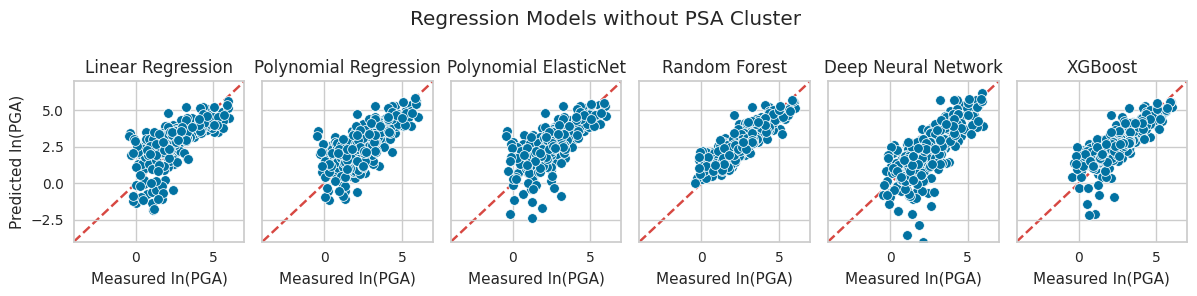

In [388]:
models_without_psa = ['Linear Regression', 'Polynomial Regression', 'Polynomial ElasticNet', 'Random Forest','Deep Neural Network', 'XGBoost']

fig, axes = plt.subplots(1, len(models_without_psa), figsize=(12, 3), sharey=True)
fig.suptitle('Regression Models without PSA Cluster')

i=0
for model in models_without_psa:
  #pipeline_name = list(trained_pipelines.keys())[i]
  print(model)
  test_pred = trained_pipelines[model].predict(test_set)
  print(len(test_pred.shape))
  if(len(test_pred.shape)>1):
    test_pred = test_pred[:, 0]
  sns.scatterplot(ax=axes[i], x=np.log(test_set['peak_ground_acceleration']), y=np.log(np.abs(test_pred)))

  # --- Linha adicionada para o plot diagonal ---
  # Cria uma linha de referência (y=x)
  lims = [-4, 7]
  axes[i].plot(lims, lims, 'r--', alpha=0.75, zorder=0)
  # -----------------------------------------


  axes[i].set_xlabel('Measured ln(PGA)')
  if(i==0):
    axes[i].set_ylabel('Predicted ln(PGA)')
  axes[i].set_xlim(-4,7)
  axes[i].set_ylim(-4,7)
  axes[i].set_title(model)
  i+=1

plt.tight_layout()

plt.show()


Linear Regression with PSA clusters_spectral_means
Linear Regression 
Polynomial Regression with PSA clusters_spectral_means
Polynomial Regression 
Polynomial ElasticNet with PSA clusters_spectral_means
Polynomial ElasticNet 
Random Forest with PSA clusters_spectral_means
Random Forest 
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Deep Neural Network with PSA clusters_spectral_means
Deep Neural Network 
XGBoost with PSA clusters_spectral_means
XGBoost 


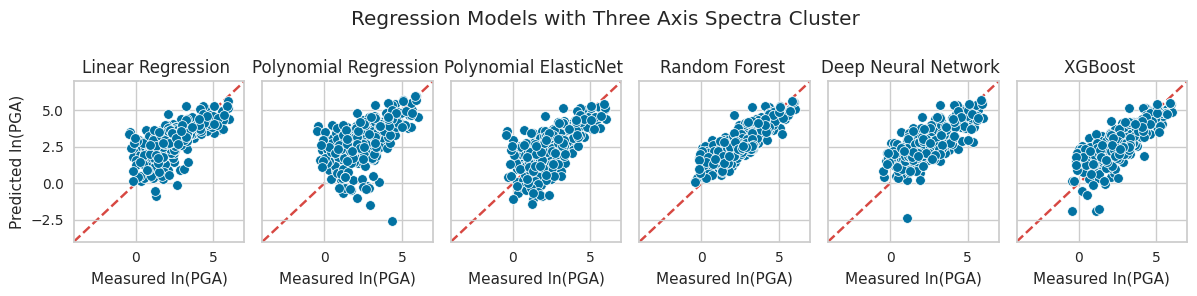

In [389]:

models_with_psa = ['Linear Regression with PSA clusters_spectral_means',
                      'Polynomial Regression with PSA clusters_spectral_means',
                      'Polynomial ElasticNet with PSA clusters_spectral_means',
                      'Random Forest with PSA clusters_spectral_means',
                      'Deep Neural Network with PSA clusters_spectral_means',
                      'XGBoost with PSA clusters_spectral_means'
                      ]

fig, axes = plt.subplots(1, len(models_with_psa), figsize=(12, 3), sharey=True)
fig.suptitle('Regression Models with Three Axis Spectra Cluster')

i=0
for model in models_with_psa:
  index = i+10
  test_pred = trained_pipelines[model].predict(test_set)
  print(model)
  plot_title = model.split('with')[0]
  print(plot_title)

  if(len(test_pred.shape)>1):
    test_pred = test_pred[:, 0]
  sns.scatterplot(ax=axes[i], x=np.log(test_set['peak_ground_acceleration']), y=np.log(np.abs(test_pred)))

  # --- Linha adicionada para o plot diagonal ---
  # Cria uma linha de referência (y=x)
  lims = [-4, 7]
  axes[i].plot(lims, lims, 'r--', alpha=0.75, zorder=0)
  # -----------------------------------------


  axes[i].set_xlabel('Measured ln(PGA)')
  if(i==0):
    axes[i].set_ylabel('Predicted ln(PGA)')
  axes[i].set_xlim(-4,7)
  axes[i].set_ylim(-4,7)
  axes[i].set_title(plot_title)
  i+=1

plt.tight_layout()

plt.show()


### Random Forest

In [390]:
trained_pipelines.keys()

dict_keys(['XGBoost', 'Random Forest with PSA clusters_spectral_vert_means', 'Polynomial ElasticNet', 'Polynomial Regression', 'Deep Neural Network', 'XGBoost with PSA clusters_spectral_coefs', 'XGBoost with PSA clusters_spectral_means', 'Random Forest with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_means', 'Polynomial Regression with PSA clusters_spectral_vert_means', 'XGBoost with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_horiz_means', 'Polynomial Regression with PSA clusters_spectral_coefs', 'Deep Neural Network with PSA clusters_spectral_vert_means', 'XGBoost with PSA clusters_spectral_vert_means', 'Linear Regression', 'Random Forest with PSA clusters_spectral_horiz_means', 'Polynomial ElasticNet with PSA clusters_spectral_means', 'Linear Regression with PSA clusters_spectral_means', 'Lin

In [391]:
model_title = 'Random Forest with Three Axis Spectra Cluster'
model_sub_title = 'With Three Axis Spectra Cluster'
pipeline_RF_without_clustering = trained_pipelines['Random Forest']
pipeline_RF_with_clustering = trained_pipelines['Random Forest with PSA clusters_spectral_means']



In [392]:
test_pred1 = pipeline_RF_without_clustering.predict(test_set)
test_pred2 = pipeline_RF_with_clustering.predict(test_set)

percent_error_1 = (test_set['peak_ground_acceleration'] - test_pred1) / test_set['peak_ground_acceleration']
percent_error_2 = (test_set['peak_ground_acceleration'] - test_pred2) / test_set['peak_ground_acceleration']

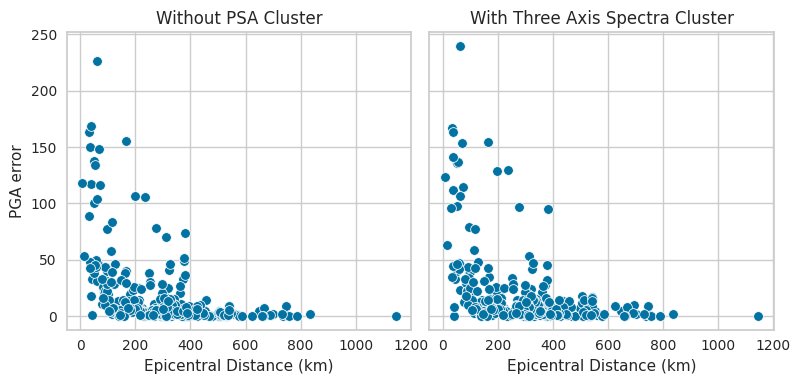

In [201]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
#fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_epicentral_distance'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_xlabel('Epicentral Distance (km)')
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')

sns.scatterplot(ax=axes[1], x=test_set['calculated_epicentral_distance'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_xlabel('Epicentral Distance (km)')
axes[1].set_ylabel('PGA error')
axes[1].set_title(model_sub_title)

plt.tight_layout()
plt.show()


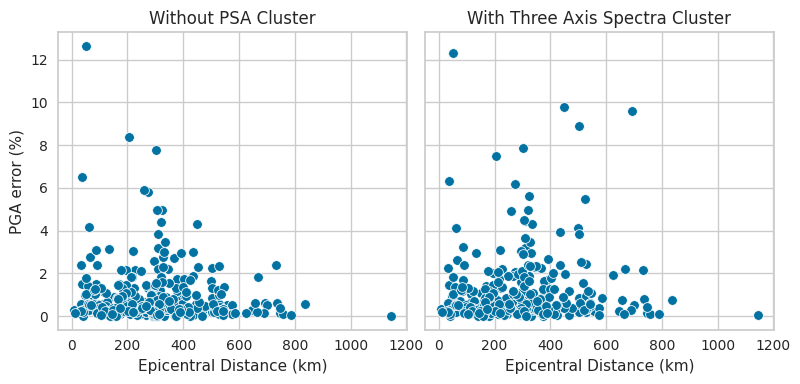

In [202]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
#fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_1))
axes[0].set_xlabel('Epicentral Distance (km)')
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')

sns.scatterplot(ax=axes[1], x=test_set['calculated_epicentral_distance'], y=np.abs(percent_error_2))
axes[1].set_xlabel('Epicentral Distance (km)')
axes[1].set_ylabel('PGA error (%)')
axes[1].set_title(model_sub_title)

plt.tight_layout()
plt.show()


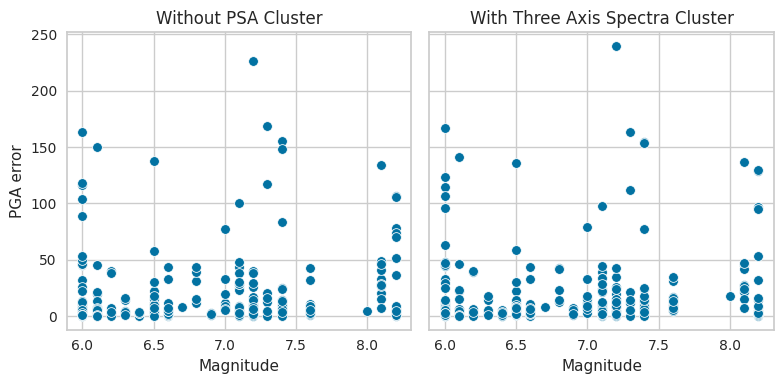

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
#fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['magnitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Magnitude')

sns.scatterplot(ax=axes[1], x=test_set['magnitude'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Magnitude')
axes[1].set_title('With Three Axis Spectra Cluster')

plt.tight_layout()
plt.show()

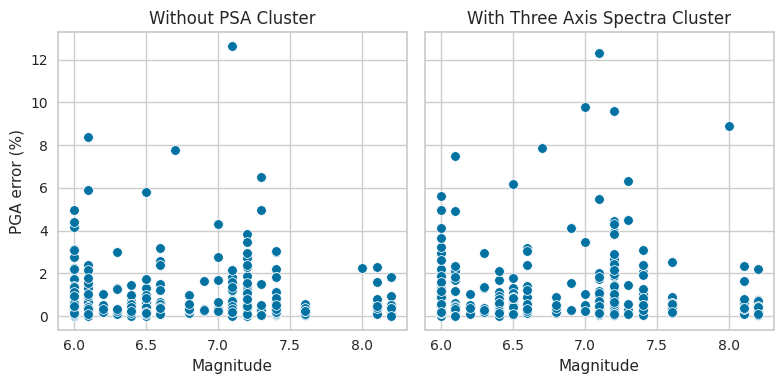

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
#fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['magnitude'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Magnitude')

sns.scatterplot(ax=axes[1], x=test_set['magnitude'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Magnitude')
axes[1].set_title('With Three Axis Spectra Cluster')

plt.tight_layout()
plt.show()

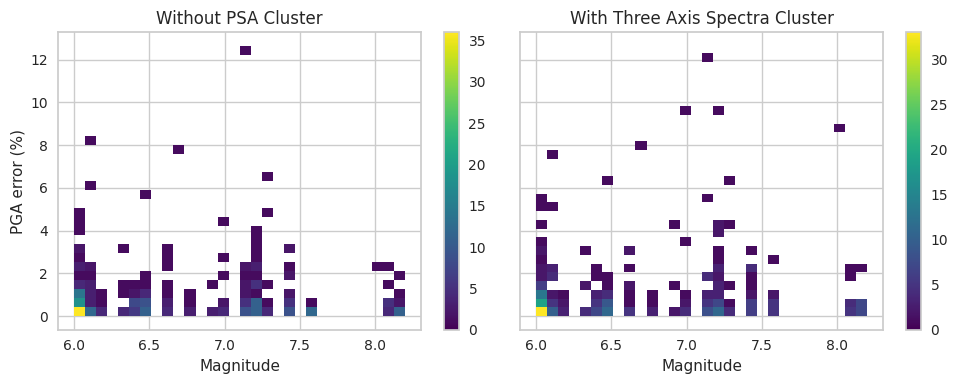

In [393]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Criando dados de exemplo para o código rodar ---
# (Você pode remover esta parte e usar seus dados reais)
# np.random.seed(42)
# test_set = pd.DataFrame({
#     'magnitude': np.random.rand(500) * 4 + 3  # Magnitudes entre 3 e 7
# })
# percent_error_1 = np.random.randn(500) * 20 * (1 / (test_set['magnitude'] - 2.5))
# percent_error_2 = np.random.randn(500) * 10 * (1 / (test_set['magnitude'] - 2.5))
# --- Fim dos dados de exemplo ---


fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Gráfico 1: Heatmap "Without PSA Cluster"
sns.histplot(
    ax=axes[0],
    x=test_set['magnitude'],
    y=np.abs(percent_error_1),
    bins=30,          # Define a "resolução" do grid
    cbar=True,        # Adiciona a barra de cores
    cmap='viridis'    # Define o esquema de cores
)
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Magnitude')

# Gráfico 2: Heatmap "With Three Axis Spectra Cluster"
sns.histplot(
    ax=axes[1],
    x=test_set['magnitude'],
    y=np.abs(percent_error_2),
    bins=30,
    cbar=True,
    cmap='viridis'
)
# axes[1].set_ylabel('PGA error (%)') # Removido pois sharey=True já compartilha o eixo
axes[1].set_xlabel('Magnitude')
axes[1].set_title('With Three Axis Spectra Cluster')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

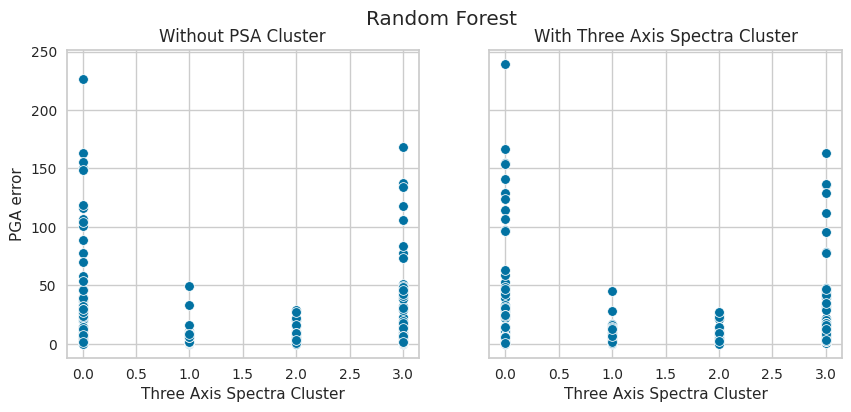

In [395]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['clusters_spectral_means'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred1)))
axes[0].set_ylabel('PGA error')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Three Axis Spectra Cluster')

sns.scatterplot(ax=axes[1], x=test_set['clusters_spectral_means'], y=(np.abs(test_set['peak_ground_acceleration'] - test_pred2)))
axes[1].set_ylabel('PGA error')
axes[1].set_xlabel('Three Axis Spectra Cluster')
axes[1].set_title('With Three Axis Spectra Cluster')

Text(0.5, 1.0, 'With Three Axis Spectra Cluster')

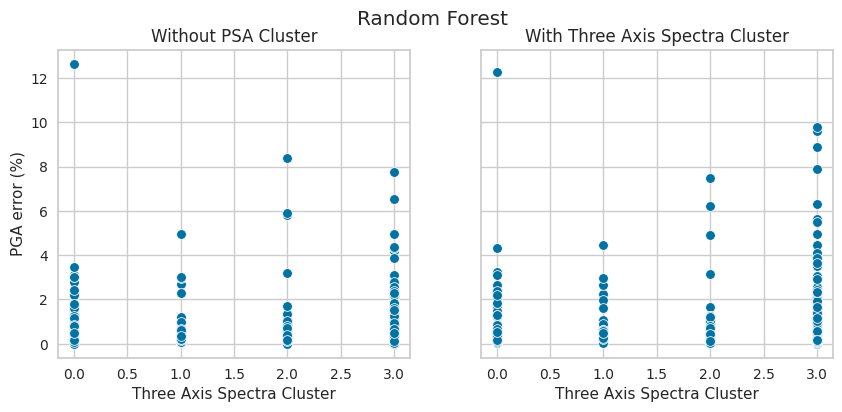

In [396]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.suptitle('Random Forest')

sns.scatterplot(ax=axes[0], x=test_set['clusters_spectral_means'], y=(np.abs(percent_error_1)))
axes[0].set_ylabel('PGA error (%)')
axes[0].set_title('Without PSA Cluster')
axes[0].set_xlabel('Three Axis Spectra Cluster')

sns.scatterplot(ax=axes[1], x=test_set['clusters_spectral_means'], y=(np.abs(percent_error_2)))
axes[1].set_ylabel('PGA error (%)')
axes[1].set_xlabel('Three Axis Spectra Cluster')
axes[1].set_title('With Three Axis Spectra Cluster')

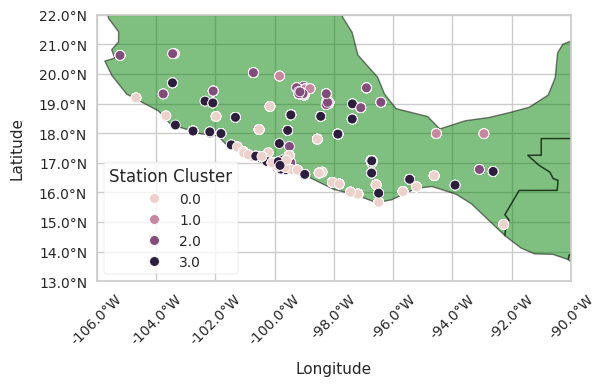

In [397]:
# Faça o plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plote o contorno do México
world.plot(ax=ax1, edgecolor='black', facecolor='green', linewidth=1, zorder=1, alpha=0.5)

# Adicionar marcadores para cada localização
# for lon, lat, name in locations:
#     ax1.plot(lon, lat, 'ko', markersize=3)
#     ax1.text(lon, lat, name, color='w', fontsize=8, ha='right', va='bottom')

# Seu scatterplot original
g = sns.scatterplot(ax=ax1,
                    data=df_com_clusters,
                    x='station_longitude',
                    y='station_latitude',
                    #size='magnitude',
                    #hue='magnitude',
                    hue='clusters_spectral_means',
                    #sizes=(40, 400),
                    s=50,
                    zorder=2,
                    #palette=sns.color_palette("Reds", as_cmap=True),
                    #marker=(8,1,0)
                    )


# Definir intervalos para os ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Intervalo de 2 graus
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Intervalo de 1 grau

# Formatar os labels com o símbolo de grau
def longitude_formatter(x, p):
    return f'{x}°W'

def latitude_formatter(x, p):
    return f'{x}°N'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(longitude_formatter))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(latitude_formatter))

# Rotacionar os labels do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Ajustar os limites e labels
ax1.set_xlabel('Longitude', labelpad=10)
ax1.set_ylabel('Latitude', labelpad=10)
plt.xlim([-106, -90])
plt.ylim([13, 22])

plt.legend(frameon=True, title='Station Cluster')


# Ajustar o layout para evitar cortes
plt.tight_layout()

plt.show()

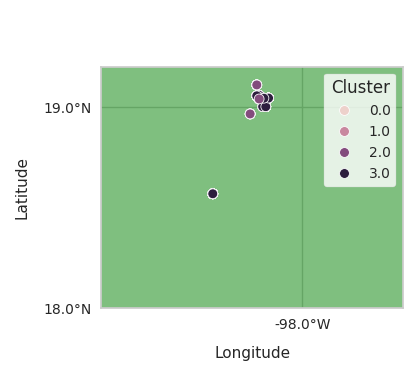

In [398]:
# Faça o plot
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plote o contorno do México
world.plot(ax=ax1, edgecolor='black', facecolor='green', linewidth=1, zorder=1, alpha=0.5)

# Adicionar marcadores para cada localização
for lon, lat, name in locations:
    ax1.plot(lon, lat, 'ko', markersize=3)
    ax1.text(lon, lat, name, color='w', fontsize=8, ha='right', va='bottom')

# Seu scatterplot original
g = sns.scatterplot(ax=ax1,
                    data=df_com_clusters,
                    x='station_longitude',
                    y='station_latitude',
                    #size='magnitude',
                    #hue='magnitude',
                    hue='clusters_spectral_means',
                    #sizes=(40, 400),
                    s=50,
                    zorder=2,
                    #palette=sns.color_palette("Reds", as_cmap=True),
                    #marker=(8,1,0)
                    )


# Definir intervalos para os ticks
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Intervalo de 2 graus
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Intervalo de 1 grau

# Formatar os labels com o símbolo de grau
def longitude_formatter(x, p):
    return f'{x}°W'

def latitude_formatter(x, p):
    return f'{x}°N'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(longitude_formatter))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(latitude_formatter))

# Rotacionar os labels do eixo x para melhor legibilidade
#plt.xticks(rotation=45)

# Ajustar os limites e labels
ax1.set_xlabel('Longitude', labelpad=10)
ax1.set_ylabel('Latitude', labelpad=10)
plt.xlim([-99, -97.5])
plt.ylim([18, 19.2])


#plt.legend(frameon=True, title='Three Axis Spectra Cluster')
plt.legend(frameon=True, title='Cluster')


# Ajustar o layout para evitar cortes
plt.tight_layout()

plt.show()

In [399]:
df_com_clusters.clusters_spectral_means.value_counts()

,count
clusters_spectral_means,
3.0,568
0.0,520
2.0,322
1.0,202


In [400]:
df_com_clusters[df_com_clusters.clusters_spectral_means == 3].soil_type.value_counts()

,count
soil_type,
roca,425
unknown,28
roca (cono volcánico),21
blando,20
"roca, cantera",16
aluvial,15
estructura,11
deposito barra,11
depósitos lacustres,8


In [401]:
test_set

,date,time,magnitude,institution,entity,station_key,station_name,peak_ground_acceleration,quality,file,...,calculated_azimuth,log_incidence_angle,magnitude_cat,peak_ground_acceleration_cat,calculated_epicentral_distance_cat,depth_cat,clusters_spectral_coefs,clusters_spectral_means,clusters_spectral_horiz_means,clusters_spectral_vert_means
492,1998-02-03,03:02:01,6.4,I de I-UNAM,PUE,RABO,RABOSO,1.62,A,RABO9802.031,...,-34.426628,1.582179,2,1,5,4,2.0,3.0,1.0,0.0
1083,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,-68.599093,1.942469,2,7,2,3,2.0,0.0,3.0,3.0
764,1999-09-30,16:31:14,7.4,I de I-UNAM,GRO,COPL,COPALA,30.14,A,COPL9909.301,...,-73.540856,1.424078,4,7,3,2,0.0,3.0,1.0,0.0
755,2017-09-08,04:49:17,8.2,I de I-UNAM,COL,COMA,COMALA,3.02,A,COMA1709.081,...,-62.476390,0.830859,4,2,6,4,3.0,2.0,2.0,2.0
817,2011-12-11,01:47:25,6.5,I de I-UNAM,PUE,CHFL,CHILA DE LAS FLORES,5.42,A,CHFL1112.111,...,85.983291,2.613639,2,3,3,5,1.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,2016-05-08,07:33:59,6.0,I de I-UNAM,GRO,ACAR,ACAPULCO RENACIMIENTO,5.90,A,ACAR1605.081,...,-73.036990,2.210218,1,3,3,4,2.0,0.0,3.0,3.0
1544,2010-06-30,07:22:27,6.0,I de I-UNAM,OAX,PNTP,PINOTEPA NACIONAL,353.43,A,PNTP1006.301,...,-31.470416,3.450975,1,8,1,1,2.0,0.0,3.0,3.0
880,2012-03-20,18:02:47,7.4,I de I-UNAM,OAX,JAMI,JAMILTEPEC,293.51,A,JAMI1203.202,...,88.014173,2.582566,4,8,1,2,1.0,0.0,3.0,3.0
1365,2016-05-08,07:33:59,6.0,I de I-UNAM,GRO,TNLP,TONALAPA DEL SUR,2.47,A,TNLP1605.081,...,-42.144422,2.015820,1,2,3,4,2.0,3.0,3.0,0.0


In [402]:
simulation = test_set[test_set.index == 1083].copy()


In [403]:
simulation.iloc[0]

,1083
date,2017-09-23 00:00:00
time,12:53:04
magnitude,6.1
institution,I de I-UNAM
entity,OAX
station_key,OAXM
station_name,OAXACA FACULTAD DE MEDICINA
peak_ground_acceleration,43.85
quality,B
file,OAXM1709.232


In [404]:
pipeline_RF_with_clustering.predict(simulation)

array([21.12750894])

In [405]:
simulation.columns

Index(['date', 'time', 'magnitude', 'institution', 'entity', 'station_key',
       'station_name', 'peak_ground_acceleration', 'quality', 'file',
       'epicentral_distance', 'soil_type', 'depth', 'earthquake_latitude',
       'earthquake_longitude', 'location_reference', 'station_latitude',
       'station_longitude', 'duration', 'incidence_angle',
       'hypocentral_distance', 'azimuth',
       'angle_to_the_nearest_horizontal_sensor',
       'calculated_epicentral_distance', 'calculated_hypocentral_distance',
       'calculated_incidence_angle', 'source_off_shore', 'calculated_azimuth',
       'log_incidence_angle', 'magnitude_cat', 'peak_ground_acceleration_cat',
       'calculated_epicentral_distance_cat', 'depth_cat',
       'clusters_spectral_coefs', 'clusters_spectral_means',
       'clusters_spectral_horiz_means', 'clusters_spectral_vert_means'],
      dtype='object')

In [406]:
simulation.clusters_spectral_means

,clusters_spectral_means
1083,0.0


In [407]:
simulation = simulation.reset_index(drop=True)
simulation

,date,time,magnitude,institution,entity,station_key,station_name,peak_ground_acceleration,quality,file,...,calculated_azimuth,log_incidence_angle,magnitude_cat,peak_ground_acceleration_cat,calculated_epicentral_distance_cat,depth_cat,clusters_spectral_coefs,clusters_spectral_means,clusters_spectral_horiz_means,clusters_spectral_vert_means
0,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,-68.599093,1.942469,2,7,2,3,2.0,0.0,3.0,3.0


In [408]:
pred = pipeline_RF_with_clustering.predict(simulation)[0]
simulation['pga_pred'] = pred

for i in range(0,4):
  simulation2 = simulation[simulation.index == 0].copy()
  simulation2.clusters_spectral_means = i
  pred = pipeline_RF_with_clustering.predict(simulation2)[0]
  simulation2['pga_pred'] = pred
  simulation = pd.concat([simulation, simulation2])
  simulation = simulation.reset_index(drop=True)

simulation

,date,time,magnitude,institution,entity,station_key,station_name,peak_ground_acceleration,quality,file,...,log_incidence_angle,magnitude_cat,peak_ground_acceleration_cat,calculated_epicentral_distance_cat,depth_cat,clusters_spectral_coefs,clusters_spectral_means,clusters_spectral_horiz_means,clusters_spectral_vert_means,pga_pred
0,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,1.942469,2,7,2,3,2.0,0.0,3.0,3.0,21.127509
1,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,1.942469,2,7,2,3,2.0,0.0,3.0,3.0,21.127509
2,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,1.942469,2,7,2,3,2.0,1.0,3.0,3.0,26.410559
3,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,1.942469,2,7,2,3,2.0,2.0,3.0,3.0,17.090411
4,2017-09-23,12:53:04,6.1,I de I-UNAM,OAX,OAXM,OAXACA FACULTAD DE MEDICINA,43.85,B,OAXM1709.232,...,1.942469,2,7,2,3,2.0,3.0,3.0,3.0,21.173381


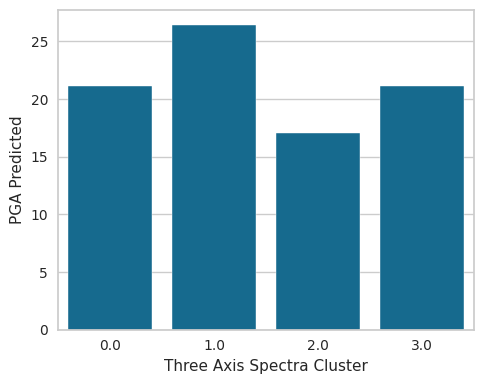

In [409]:
fig, ax = plt.subplots(figsize=(5, 4)) # width and height in inches

p = sns.barplot(data=simulation, x="clusters_spectral_means", y="pga_pred", ax=ax)
p.set(xlabel="Three Axis Spectra Cluster")
p.set(ylabel="PGA Predicted")

plt.tight_layout()
plt.show()
